### loading necessary imports

In [11]:
# ==========================================================
#  Standard Libraries
# ==========================================================
import os, re, time, glob, json, pickle, warnings
from itertools import combinations
from pathlib import Path

# ==========================================================
#  Data Handling & Computation
# ==========================================================
import numpy as np
import pandas as pd
import joblib

# ==========================================================
#  Visualization & Explainability
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm
from IPython.display import display
from matplotlib.lines import Line2D
from matplotlib.ticker import PercentFormatter

# ==========================================================
#  Machine Learning - Core
# ==========================================================
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, train_test_split
)
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# ==========================================================
#  Evaluation Metrics
# ==========================================================
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix, accuracy_score, precision_score, recall_score,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

# ==========================================================
#  Calibration Display (CORRECTED IMPORT)
# ==========================================================
from sklearn.calibration import CalibrationDisplay

# ==========================================================
#  Imbalanced Data Handling
# ==========================================================
import sklearn
import imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks

# ==========================================================
#  Machine Learning Models
# ==========================================================
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ==========================================================
#  Hyperparameter Optimization
# ==========================================================
import optuna
from optuna.pruners import MedianPruner
from optuna.trial import TrialState

# ==========================================================
#  Settings & Configuration
# ==========================================================

# COMPLETE SUPPRESSION OF ALL WARNINGS
warnings.filterwarnings('ignore')

# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Suppress Optuna completely
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
os.environ['OPTUNA_DISABLE_IMPORT_CHECK'] = '1'

# Suppress LightGBM completely
os.environ['LIGHTGBM_VERBOSE'] = '-1'

# Suppress other libraries
import logging
logging.getLogger('lightgbm').setLevel(logging.ERROR)
logging.getLogger('optuna').setLevel(logging.ERROR)
logging.getLogger('joblib').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('shap').setLevel(logging.ERROR)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linestyle'] = '--'

# Pandas display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set style for better visualizations
sns.set_palette("husl")

### loading the data

In [12]:
import logging
import pandas as pd
import numpy as np
from pathlib import Path

# Set up a basic logger for notebook use
logger = logging.getLogger("model_training")
if not logger.hasHandlers():
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def prepare_data(artifacts_path: Path):
    """
    Loads the already split heart disease data from artifacts folder.
    Loads all features but only uses the 3 scores for modeling.
    No scaling needed as scores are already engineered.
    """
    # Define Feature Sets - ONLY THE 3 SCORES for modeling
    modeling_features = [
        'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score'
    ]
    
    # Load already split data from artifacts (all features)
    logger.info(f"Loading split data from artifacts folder: {artifacts_path}")
    
    try:
        # Load all features
        X_train_full = pd.read_parquet(artifacts_path / 'X_train.parquet')
        X_test_full = pd.read_parquet(artifacts_path / 'X_test.parquet')
        y_train = pd.read_parquet(artifacts_path / 'y_train.parquet')
        y_test = pd.read_parquet(artifacts_path / 'y_test.parquet')
        
        # Select only the 3 scores for modeling
        X_train = X_train_full[modeling_features]
        X_test = X_test_full[modeling_features]
        
    except FileNotFoundError as e:
        logger.error(f"Split data files not found in artifacts folder: {e}")
        raise
    
    # Ensure y data is in proper format (series if stored as dataframe)
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0] if len(y_train.columns) > 0 else y_train.squeeze()
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0] if len(y_test.columns) > 0 else y_test.squeeze()

    logger.info("Data loaded successfully - All features loaded, but using only 3 pre-engineered scores for modeling")
    logger.info("No scaling applied - scores are already properly engineered")
    logger.info(f"Full train set features: {X_train_full.shape[1]} columns")
    logger.info(f"Full test set features: {X_test_full.shape[1]} columns")
    logger.info(f"Modeling features: {modeling_features}")
    logger.info(f"Train set for modeling: {X_train.shape}, Test set for modeling: {X_test.shape}")

    # Return both full datasets and modeling datasets
    return X_train, X_test, y_train, y_test, modeling_features, X_train_full, X_test_full

if __name__ == '__main__':
    try:
        PROJECT_ROOT = Path(__file__).resolve().parents[2]
    except NameError:
        PROJECT_ROOT = Path().resolve().parent.parent

    ARTIFACTS_PATH = PROJECT_ROOT / 'artifacts'

    try:
        X_train, X_test, y_train, y_test, modeling_features, X_train_full, X_test_full = prepare_data(artifacts_path=ARTIFACTS_PATH)

        print("Data preparation completed successfully")
        print(f"Full train set: {X_train_full.shape} (all features)")
        print(f"Full test set: {X_test_full.shape} (all features)")
        print(f"Modeling train set: {X_train.shape} (scores only)")
        print(f"Modeling test set: {X_test.shape} (scores only)")
        print(f"Modeling features: {modeling_features}")
        print(f"All available features: {list(X_train_full.columns)}")
        print(f"Target distribution - Train: {y_train.value_counts().to_dict()}")
        print(f"Target distribution - Test: {y_test.value_counts().to_dict()}")
        
    except FileNotFoundError as e:
        logger.error(f"Files not found in artifacts folder: {e}")
    except Exception as e:
        logger.error(f"Error during data preparation: {e}")
        raise

2025-10-15 16:44:38,346 - model_training - INFO - Loading split data from artifacts folder: P:\projects\heart_disease_prediction\artifacts
2025-10-15 16:44:38,376 - model_training - INFO - Data loaded successfully - All features loaded, but using only 3 pre-engineered scores for modeling
2025-10-15 16:44:38,376 - model_training - INFO - No scaling applied - scores are already properly engineered
2025-10-15 16:44:38,376 - model_training - INFO - Full train set features: 15 columns
2025-10-15 16:44:38,387 - model_training - INFO - Full test set features: 15 columns
2025-10-15 16:44:38,387 - model_training - INFO - Modeling features: ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
2025-10-15 16:44:38,387 - model_training - INFO - Train set for modeling: (48983, 3), Test set for modeling: (20993, 3)


Data preparation completed successfully
Full train set: (48983, 15) (all features)
Full test set: (20993, 15) (all features)
Modeling train set: (48983, 3) (scores only)
Modeling test set: (20993, 3) (scores only)
Modeling features: ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
All available features: ['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 'BMI', 'BP_level', 'Pulse_Pressure', 'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
Target distribution - Train: {0: 24503, 1: 24480}
Target distribution - Test: {0: 10501, 1: 10492}


### finding the best model with calibration

In [14]:
import xgboost as xgb
import lightgbm as lgb
import shutil
import numpy as np
from pathlib import Path
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
import joblib
import optuna
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
import os
from tqdm.auto import tqdm
import warnings

# Suppress all warnings and Optuna logs
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.ERROR)

# ==========================================================
# HEART DISEASE MODELING: XGBoost vs LightGBM (Optuna + Calibration)
# ==========================================================
# CORRECTED PATH LOGIC
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

# Define directories
REPORTS_DIR = project_root / "reports"
ARTIFACTS_DIR = project_root / "artifacts"
SAVE_DIR = REPORTS_DIR / "modeling" / "best model"

# Only create directories if they don't exist
if not REPORTS_DIR.exists():
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
if not ARTIFACTS_DIR.exists():
    ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
if not SAVE_DIR.exists():
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Reports directory: {REPORTS_DIR}")
print(f"Artifacts directory: {ARTIFACTS_DIR}")
print(f"Model save directory: {SAVE_DIR}")

# ==========================================================
# Remove existing model files if they exist (overwrite behavior)
# ==========================================================
model_files = [
    "xgboost_best_params.pkl",
    "lightgbm_best_params.pkl", 
    "xgboost_calibrated_model.pkl",
    "lightgbm_calibrated_model.pkl",
]

for model_file in model_files:
    file_path = SAVE_DIR / model_file
    if file_path.exists():
        os.remove(file_path)
        print(f"Removed existing file: {file_path}")

# ==========================================================
# Train Logistic Regression for Feature Importance Baseline
# ==========================================================
lr_baseline = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
lr_baseline.fit(X_train, y_train)

# Get Logistic Regression feature importances (absolute coefficients)
lr_weights = np.abs(lr_baseline.coef_[0])
lr_weights_normalized = lr_weights / np.sum(lr_weights)

# ==========================================================
# Enhanced Early Stopping Callback for Optuna with Progress Tracking
# ==========================================================
class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    pass

class EarlyStoppingCallback:
    def __init__(self, early_stopping_rounds: int, direction: str = "maximize", total_trials: int = 50):
        self.early_stopping_rounds = early_stopping_rounds
        self.direction = direction
        self.total_trials = total_trials
        self._best_value = None
        self._no_improvement_count = 0
        self._current_trial = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        self._current_trial += 1
        current_value = trial.value
        
        if current_value is None:
            return

        if self._best_value is None:
            self._best_value = current_value
            return

        if self.direction == "maximize":
            improved = current_value > self._best_value
        else:
            improved = current_value < self._best_value

        if improved:
            self._best_value = current_value
            self._no_improvement_count = 0
        else:
            self._no_improvement_count += 1

        if (self._current_trial >= 20 and
            self._no_improvement_count >= self.early_stopping_rounds and
            self._current_trial < self.total_trials):
            raise EarlyStoppingExceeded()

# ==========================================================
# Custom Wrapper for Progress Bar in Optuna Optimization
# ==========================================================
def optimize_with_progress(study, objective, n_trials, callbacks, model_name):
    pbar = tqdm(total=n_trials, desc=f"Optimizing {model_name}", position=0, leave=True)
    
    def callback_with_progress(study, trial):
        pbar.update(1)
        pbar.set_postfix({
            "Best Score": f"{study.best_value:.4f}",
            "Trial": f"{trial.number + 1}/{n_trials}"
        })
        for cb in callbacks:
            cb(study, trial)
    
    try:
        study.optimize(objective, n_trials=n_trials, callbacks=[callback_with_progress], show_progress_bar=False)
    except EarlyStoppingExceeded:
        pbar.close()
        return True
    except Exception as e:
        pbar.close()
        raise
    else:
        pbar.close()
        return False

# ==========================================================
# XGBoost Objective Function with LR Weight Penalty
# ==========================================================
def objective_xgb_with_penalty(trial):
    penalty_strength = trial.suggest_float("penalty_strength", 0.0, 2.0)

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "subsample": trial.suggest_float("subsample", 0.75, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "random_state": 42,
        "tree_method": "hist",
        "n_jobs": -1,
        "eval_metric": "logloss",
        "verbosity": 0
    }
    
    model = xgb.XGBClassifier(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    auc_score = np.mean(scores)

    model.fit(X_train, y_train)
    
    xgb_importances = model.feature_importances_
    xgb_importances_normalized = xgb_importances / np.sum(xgb_importances)

    penalty = np.mean((xgb_importances_normalized - lr_weights_normalized) ** 2)

    final_score = auc_score - (penalty * penalty_strength)

    return final_score

# ==========================================================
# LightGBM Objective Function with LR Weight Penalty
# ==========================================================
def objective_lgb_with_penalty(trial):
    penalty_strength = trial.suggest_float("penalty_strength", 0.0, 2.0)

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
        "subsample": trial.suggest_float("subsample", 0.75, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.95),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 30),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 0.1),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.2),
        "random_state": 42,
        "device": "cpu",
        "n_jobs": -1,
        "verbose": -1
    }
    
    model = lgb.LGBMClassifier(**params)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    auc_score = np.mean(scores)

    model.fit(X_train, y_train)
    
    lgb_importances = model.feature_importances_
    lgb_importances_normalized = lgb_importances / np.sum(lgb_importances)

    penalty = np.mean((lgb_importances_normalized - lr_weights_normalized) ** 2)

    final_score = auc_score - (penalty * penalty_strength)

    return final_score

# ==========================================================
# Run Optuna Optimization with LR Weight Penalty
# ==========================================================
print("Starting model optimization with feature importance alignment...")

# XGBoost optimization with early stopping
study_xgb = optuna.create_study(direction="maximize", study_name="XGBoost_LR_Penalty")
early_stopping_callback_xgb = EarlyStoppingCallback(
    early_stopping_rounds=12,
    direction="maximize", 
    total_trials=50
)

xgb_stopped_early = optimize_with_progress(
    study_xgb, 
    objective_xgb_with_penalty, 
    n_trials=50, 
    callbacks=[early_stopping_callback_xgb],
    model_name="XGBoost"
)

# LightGBM optimization with early stopping
study_lgb = optuna.create_study(direction="maximize", study_name="LightGBM_LR_Penalty")
early_stopping_callback_lgb = EarlyStoppingCallback(
    early_stopping_rounds=12,
    direction="maximize", 
    total_trials=50
)

lgb_stopped_early = optimize_with_progress(
    study_lgb, 
    objective_lgb_with_penalty, 
    n_trials=50, 
    callbacks=[early_stopping_callback_lgb],
    model_name="LightGBM"
)

# ==========================================================
# Select Best Model
# ==========================================================
def check_generalization(model, model_name):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)
    
    return cv_mean, cv_std

# Select best model based on CV performance
if study_xgb.best_value >= study_lgb.best_value:
    best_model_name = "xgboost"
    best_params = study_xgb.best_params
    final_params = {k: v for k, v in best_params.items() if k != "penalty_strength"}
    final_params.update({
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
        "eval_metric": "logloss",
        "verbosity": 0
    })
    final_model = xgb.XGBClassifier(**final_params)
    cv_score, cv_std = check_generalization(final_model, "XGBoost")
else:
    best_model_name = "lightgbm"
    best_params = study_lgb.best_params
    final_params = {k: v for k, v in best_params.items() if k != "penalty_strength"}
    final_params.update({
        "device": "cpu",
        "random_state": 42,
        "n_jobs": -1,
        "verbose": -1
    })
    final_model = lgb.LGBMClassifier(**final_params)
    cv_score, cv_std = check_generalization(final_model, "LightGBM")

# ==========================================================
# Train Final Model with Calibration
# ==========================================================
calibrated_model = CalibratedClassifierCV(
    estimator=final_model,
    method="isotonic", 
    cv=5,
    n_jobs=-1
)

calibrated_model.fit(X_train, y_train)

# ==========================================================
# Save Model & Parameters (automatically overwrites)
# ==========================================================
joblib.dump(best_params, SAVE_DIR / f"{best_model_name}_best_params.pkl")
joblib.dump(calibrated_model, SAVE_DIR / f"{best_model_name}_calibrated_model.pkl")

# Also save the other model's parameters for reference
if best_model_name == "xgboost":
    other_params = {k: v for k, v in study_lgb.best_params.items() if k != "penalty_strength"}
    joblib.dump(other_params, SAVE_DIR / "lightgbm_best_params.pkl")
else:
    other_params = {k: v for k, v in study_xgb.best_params.items() if k != "penalty_strength"}
    joblib.dump(other_params, SAVE_DIR / "xgboost_best_params.pkl")

# ==========================================================
# Save Training Summary (overwrites if exists)
# ==========================================================
summary_content = f"""
MODEL TRAINING SUMMARY
======================

Best Model: {best_model_name.upper()}
Selection Criteria: Optuna optimization with LR weight penalty

PERFORMANCE METRICS:
- Train ROC AUC: {roc_auc_score(y_train, calibrated_model.predict_proba(X_train)[:, 1]):.4f}
- Test ROC AUC: {roc_auc_score(y_test, calibrated_model.predict_proba(X_test)[:, 1]):.4f}
- Test Average Precision: {average_precision_score(y_test, calibrated_model.predict_proba(X_test)[:, 1]):.4f}
- CV Score: {cv_score:.4f} ± {cv_std:.4f}

OPTIMIZATION DETAILS:
- XGBoost Trials: {len(study_xgb.trials)}, Best Score: {study_xgb.best_value:.4f}
- LightGBM Trials: {len(study_lgb.trials)}, Best Score: {study_lgb.best_value:.4f}
- Early Stopping: XGBoost({xgb_stopped_early}), LightGBM({lgb_stopped_early})

FEATURE IMPORTANCE ALIGNMENT:
- Used Logistic Regression weights as baseline
- Penalty applied for feature importance divergence

CALIBRATION:
- Method: Isotonic
- CV Folds: 5

TIMESTAMP: {np.datetime64('now')}
"""

# Save summary to file (overwrites if exists)
with open(SAVE_DIR / "training_summary.txt", "w") as f:
    f.write(summary_content)

# ==========================================================
# Final Results
# ==========================================================
y_pred_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_calibrated)
avg_precision = average_precision_score(y_test, y_pred_calibrated)
y_pred_train = calibrated_model.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred_train)
performance_gap = roc_auc_train - roc_auc

print(f"\nOptimization completed:")
print(f"Best model: {best_model_name.upper()}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Test Avg Precision: {avg_precision:.4f}")
print(f"Performance gap (train-test): {performance_gap:.4f}")
print(f"CV stability: {cv_std:.4f}")
print(f"Models saved to: {SAVE_DIR.resolve()}")

Project root: P:\projects\heart_disease_prediction
Reports directory: P:\projects\heart_disease_prediction\reports
Artifacts directory: P:\projects\heart_disease_prediction\artifacts
Model save directory: P:\projects\heart_disease_prediction\reports\modeling\best model
Removed existing file: P:\projects\heart_disease_prediction\reports\modeling\best model\xgboost_best_params.pkl
Removed existing file: P:\projects\heart_disease_prediction\reports\modeling\best model\lightgbm_best_params.pkl
Removed existing file: P:\projects\heart_disease_prediction\reports\modeling\best model\lightgbm_calibrated_model.pkl
Starting model optimization with feature importance alignment...


Optimizing LightGBM:  62%|██████▏   | 31/50 [02:43<01:40,  5.28s/it, Best Score=0.7919, Trial=31/50]



Optimization completed:
Best model: XGBOOST
Test ROC AUC: 0.7949
Test Avg Precision: 0.7771
Performance gap (train-test): 0.0111
CV stability: 0.0050
Models saved to: P:\projects\heart_disease_prediction\reports\modeling\best model


### evaluation metrics


Classification Report (Threshold = 0.442):
               precision    recall  f1-score   support

      Healthy       0.74      0.70      0.72     10501
Heart Disease       0.72      0.75      0.73     10492

     accuracy                           0.73     20993
    macro avg       0.73      0.73      0.73     20993
 weighted avg       0.73      0.73      0.73     20993



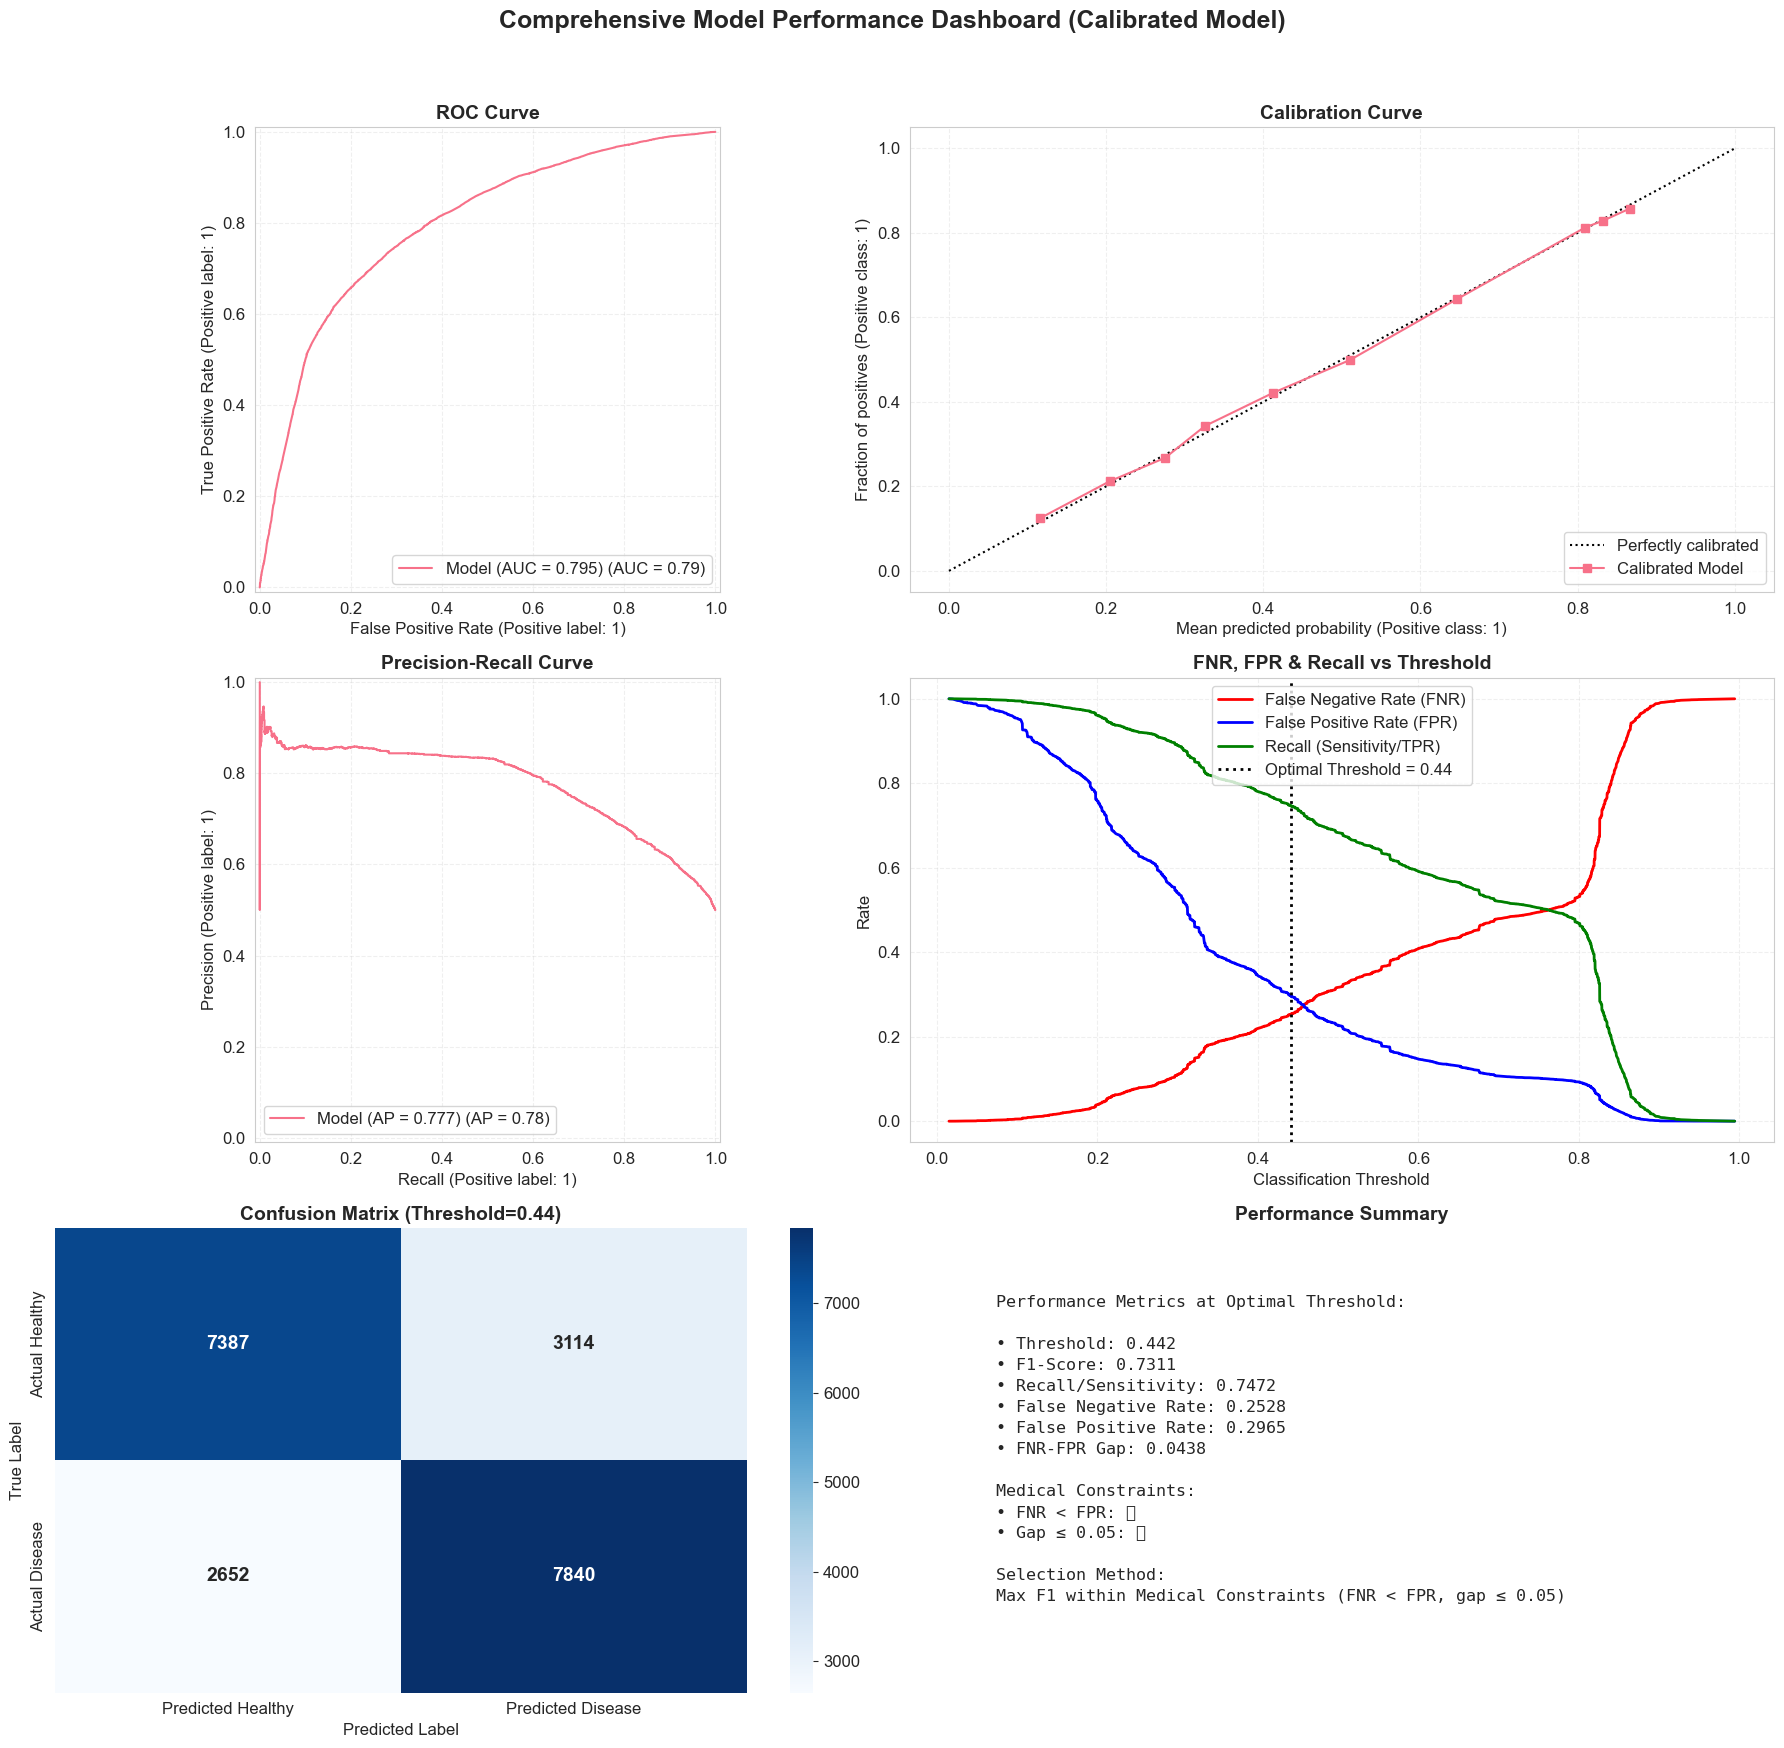


Performance Summary:
  ROC AUC: 0.7949
  Avg Precision: 0.7771
  Optimal Threshold: 0.442
  F1-Score: 0.7311
  Recall: 0.7472
  FNR: 0.2528, FPR: 0.2965
  Medical constraints met: True
  Dashboard saved to: P:\projects\heart_disease_prediction\reports\modeling\figures\1_performance_dashboard.png


In [15]:
# ==========================================================
# PERFORMANCE DASHBOARD WITH MEDICAL CONSTRAINTS
# ==========================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, 
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import CalibrationDisplay
from pathlib import Path

# ==========================================================
# Determine Project Root and Figures Folder
# ==========================================================
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

FIGURES_DIR = project_root / "reports/modeling/figures"

# Only create directory if it doesn't exist
if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# ==========================================================
# Predictions using calibrated model
# ==========================================================
y_true = y_test
y_prob = calibrated_model.predict_proba(X_test)[:, 1]

# ==========================================================
# Compute ROC, PR, AUC
# ==========================================================
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)
avg_precision = average_precision_score(y_true, y_prob)

# ==========================================================
# Compute F1 Scores
# ==========================================================
fnr = 1 - tpr
p = y_true.sum()
n = len(y_true) - p
tp = tpr * p
fp = fpr * n

f1_scores = np.divide(
    2 * tp, (2 * tp + fp + (p - tp)), out=np.zeros_like(tp), where=(2 * tp + fp + (p - tp)) > 0
)

# ==========================================================
# Custom Medical Constraints Logic: FNR < FPR and gap ≤ 0.05
# ==========================================================
gap = np.abs(fnr - fpr)
feasible_mask = (fnr < fpr) & (gap <= 0.05)

if np.any(feasible_mask):
    f1_feasible = f1_scores[feasible_mask]
    best_idx_in_feasible = np.argmax(f1_feasible)
    original_indices = np.where(feasible_mask)[0]
    optimal_idx = original_indices[best_idx_in_feasible]
    selection_method = "Max F1 within Medical Constraints (FNR < FPR, gap ≤ 0.05)"
else:
    optimal_idx = np.argmax(f1_scores)
    selection_method = "Fallback (Global Max F1-Score)"
    
best_threshold = thresholds_roc[optimal_idx]
metrics_at_best = {
    'f1': f1_scores[optimal_idx],
    'fnr': fnr[optimal_idx],
    'fpr': fpr[optimal_idx],
    'tpr': tpr[optimal_idx],
    'recall': tpr[optimal_idx],
    'gap': gap[optimal_idx]
}

# ==========================================================
# Predictions at optimal threshold for confusion matrix and classification report
# ==========================================================
y_pred_best = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_best)

# ==========================================================
# Print Classification Report
# ==========================================================
print(f"\nClassification Report (Threshold = {best_threshold:.3f}):")
print("=" * 50)
cr = classification_report(y_true, y_pred_best, target_names=['Healthy', 'Heart Disease'])
print(cr)
print("=" * 50)

# ==========================================================
# Enhanced Dashboard with Confusion Matrix (3x2 layout)
# ==========================================================
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
axes = axes.ravel()

# ROC Curve
RocCurveDisplay.from_predictions(y_true, y_prob, name=f"Model (AUC = {roc_auc:.3f})", ax=axes[0])
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Calibration Curve
CalibrationDisplay.from_predictions(y_true, y_prob, n_bins=10, strategy='quantile', 
                                   name='Calibrated Model', ax=axes[1])
axes[1].set_title('Calibration Curve', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# PR Curve
PrecisionRecallDisplay.from_predictions(y_true, y_prob, name=f"Model (AP = {avg_precision:.3f})", ax=axes[2])
axes[2].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# FNR, FPR, Recall vs Threshold
axes[3].plot(thresholds_roc, fnr, label='False Negative Rate (FNR)', lw=2, color='red')
axes[3].plot(thresholds_roc, fpr, label='False Positive Rate (FPR)', lw=2, color='blue')
axes[3].plot(thresholds_roc, tpr, label='Recall (Sensitivity/TPR)', lw=2, color='green')
axes[3].axvline(best_threshold, color='black', linestyle=':', lw=2, 
                label=f'Optimal Threshold = {best_threshold:.2f}')
axes[3].set_title('FNR, FPR & Recall vs Threshold', fontsize=14, fontweight='bold')
axes[3].set_xlabel('Classification Threshold')
axes[3].set_ylabel('Rate')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Predicted Healthy', 'Predicted Disease'], 
            yticklabels=['Actual Healthy', 'Actual Disease'],
            annot_kws={"size": 14, "weight": "bold"}, ax=axes[4])
axes[4].set_title(f'Confusion Matrix (Threshold={best_threshold:.2f})', fontsize=14, fontweight='bold')
axes[4].set_xlabel('Predicted Label')
axes[4].set_ylabel('True Label')

# Performance Metrics Summary
metrics_text = f"""
Performance Metrics at Optimal Threshold:

• Threshold: {best_threshold:.3f}
• F1-Score: {metrics_at_best['f1']:.4f}
• Recall/Sensitivity: {metrics_at_best['recall']:.4f}
• False Negative Rate: {metrics_at_best['fnr']:.4f}
• False Positive Rate: {metrics_at_best['fpr']:.4f}
• FNR-FPR Gap: {metrics_at_best['gap']:.4f}

Medical Constraints:
• FNR < FPR: {'✅' if metrics_at_best['fnr'] < metrics_at_best['fpr'] else '❌'}
• Gap ≤ 0.05: {'✅' if metrics_at_best['gap'] <= 0.05 else '❌'}

Selection Method:
{selection_method}
"""

axes[5].text(0.1, 0.9, metrics_text, transform=axes[5].transAxes, fontsize=12, 
             verticalalignment='top', fontfamily='monospace', linespacing=1.5)
axes[5].set_title('Performance Summary', fontsize=14, fontweight='bold')
axes[5].set_xticks([])
axes[5].set_yticks([])
axes[5].spines['top'].set_visible(False)
axes[5].spines['right'].set_visible(False)
axes[5].spines['bottom'].set_visible(False)
axes[5].spines['left'].set_visible(False)

plt.suptitle('Comprehensive Model Performance Dashboard (Calibrated Model)', fontsize=18, fontweight='bold', y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the dashboard with serial number
dashboard_path = FIGURES_DIR / "1_performance_dashboard.png"
plt.savefig(dashboard_path, dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================
# Print final summary
# ==========================================================
print(f"\nPerformance Summary:")
print(f"  ROC AUC: {roc_auc:.4f}")
print(f"  Avg Precision: {avg_precision:.4f}")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"  F1-Score: {metrics_at_best['f1']:.4f}")
print(f"  Recall: {metrics_at_best['recall']:.4f}")
print(f"  FNR: {metrics_at_best['fnr']:.4f}, FPR: {metrics_at_best['fpr']:.4f}")
print(f"  Medical constraints met: {np.any(feasible_mask)}")
print(f"  Dashboard saved to: {dashboard_path}")

### risk score analysis

Starting risk group analysis...
Risk groups created - Train: 48983, Test: 20993


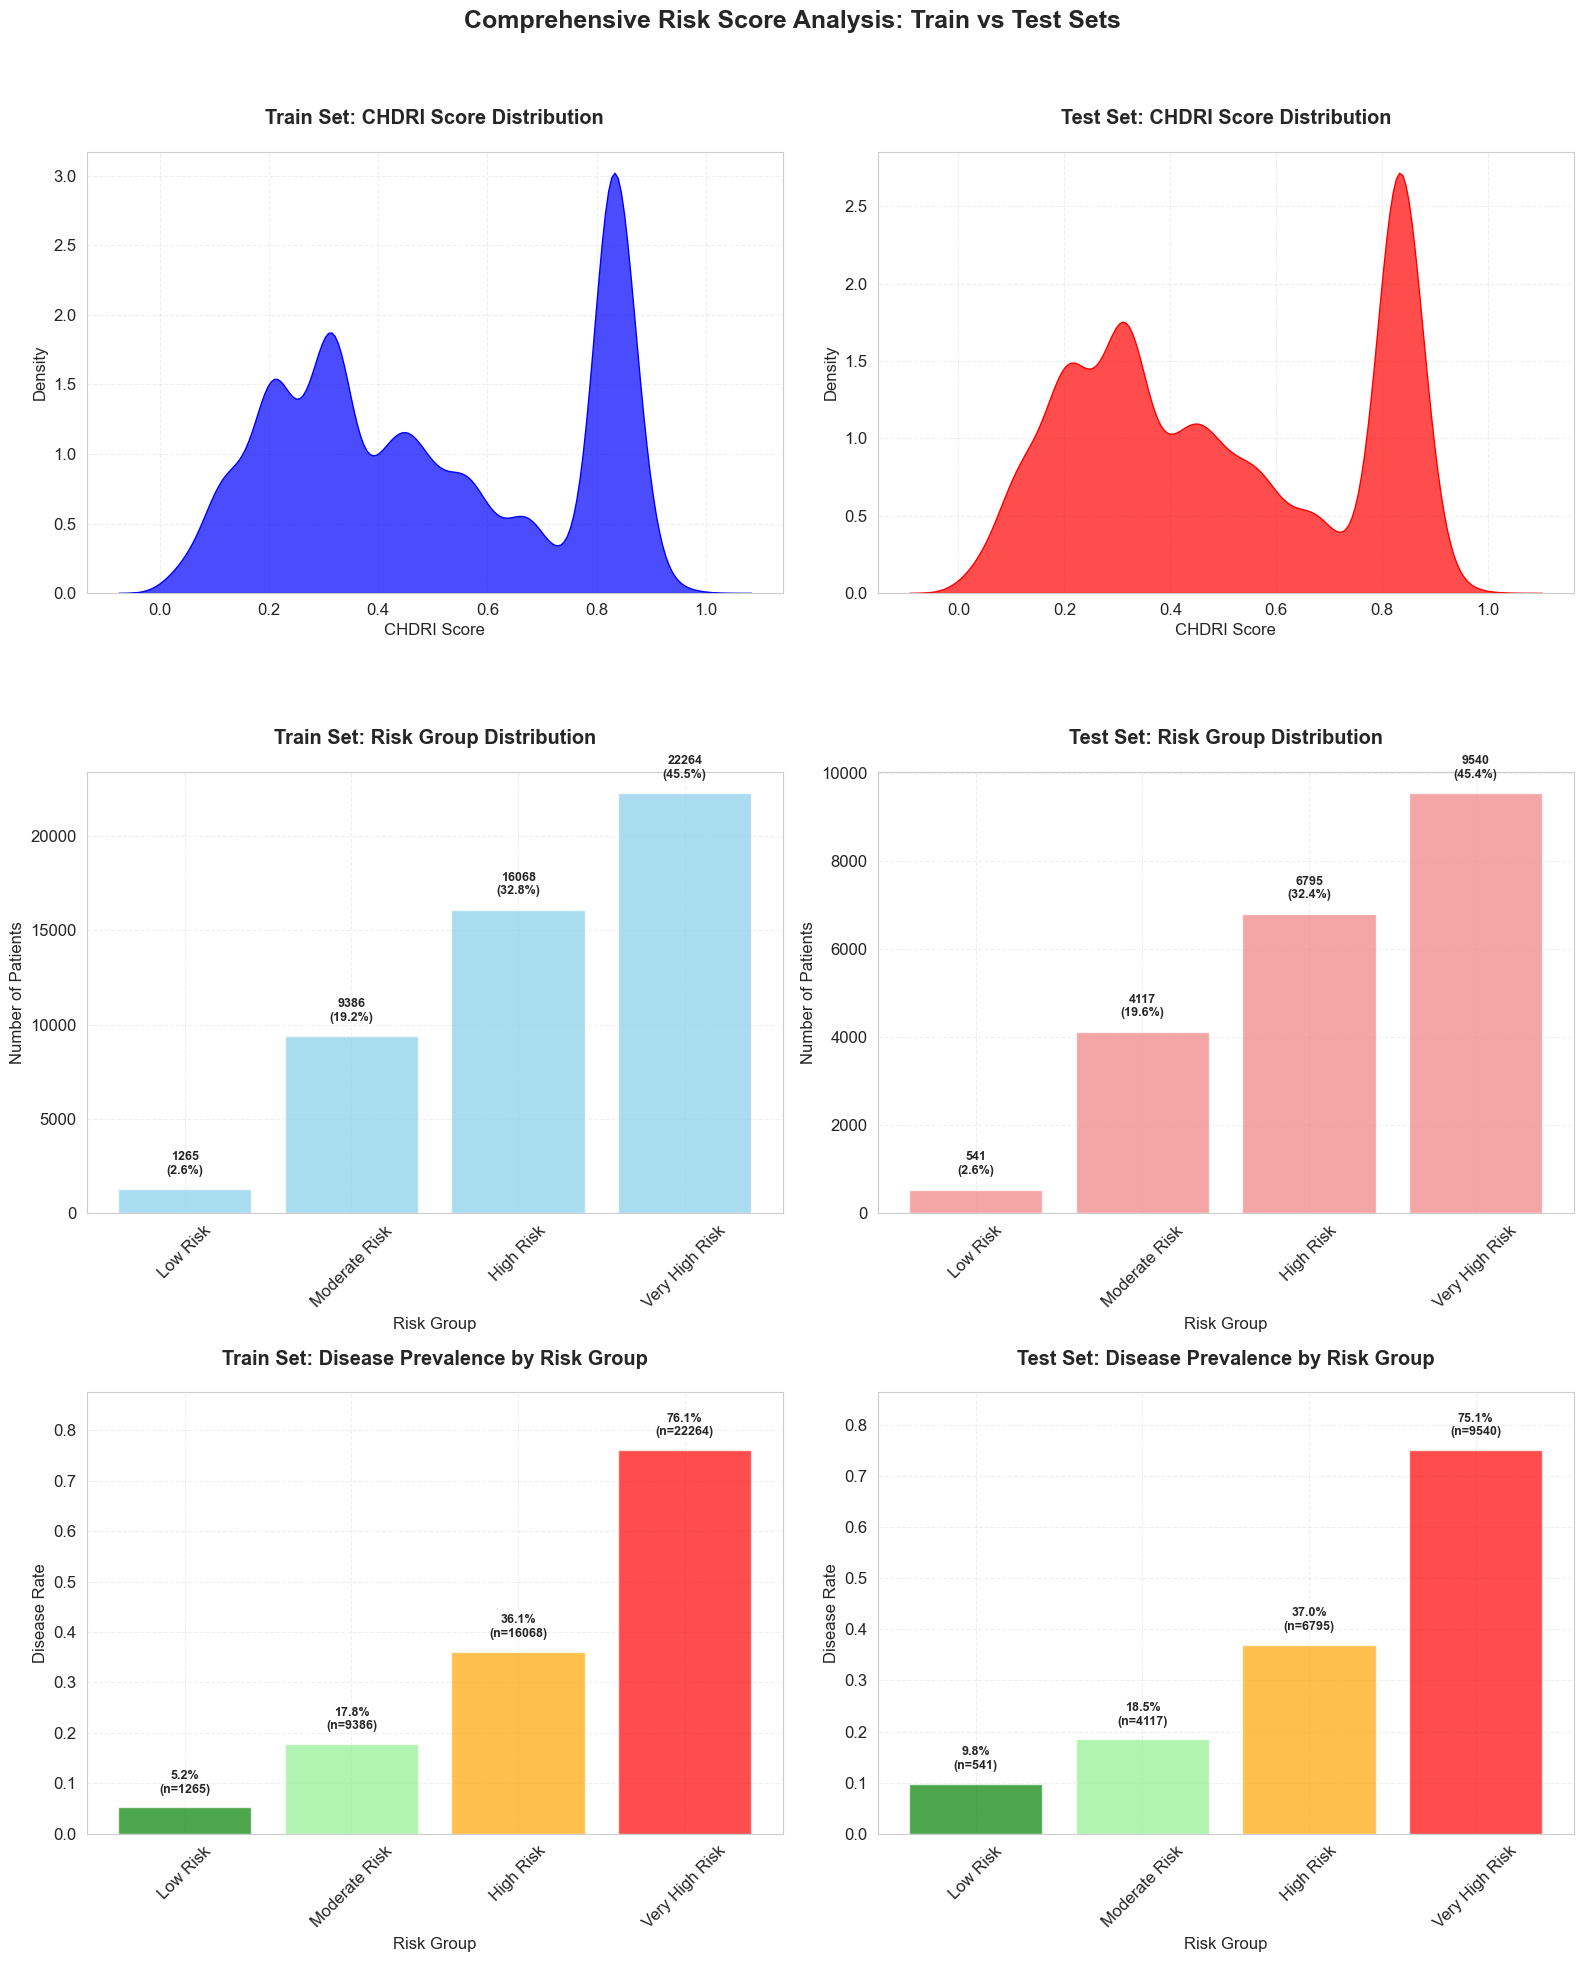


Combined visualization saved to: P:\projects\heart_disease_prediction\reports\modeling\figures/2_risk_score_analysis.png


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==========================================================
# 1. SETUP: PATH LOGIC
# ==========================================================
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

FIGURES_DIR = project_root / 'reports' / 'modeling' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Starting risk group analysis...")

# ==========================================================
# 2. RISK GROUPING LOGIC
# ==========================================================
def create_risk_groups(risk_scores):
    conditions = [
        risk_scores < 0.1,
        risk_scores < 0.25, 
        risk_scores < 0.5,
        risk_scores >= 0.5
    ]
    choices = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
    return np.select(conditions, choices, default='Error')

# ==========================================================
# 3. GENERATE RISK SCORES AND GROUPS
# ==========================================================
# Prepare DataFrames
if not hasattr(X_train, 'columns'):
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns.tolist()
    else:
        feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
    train_data = pd.DataFrame(X_train, columns=feature_names)
    test_data = pd.DataFrame(X_test, columns=feature_names)
else:
    train_data = X_train.copy()
    test_data = X_test.copy()

# Generate risk scores and groups
train_scores_df = train_data.copy()
test_scores_df = test_data.copy()

train_scores_df['CHDRI_Score'] = calibrated_model.predict_proba(train_data)[:, 1]
test_scores_df['CHDRI_Score'] = calibrated_model.predict_proba(test_data)[:, 1]

train_scores_df['Risk_Group'] = create_risk_groups(train_scores_df['CHDRI_Score'])
test_scores_df['Risk_Group'] = create_risk_groups(test_scores_df['CHDRI_Score'])

# Add actual outcomes
train_scores_df['Actual_Outcome'] = y_train
test_scores_df['Actual_Outcome'] = y_test

print(f"Risk groups created - Train: {len(train_scores_df)}, Test: {len(test_scores_df)}")

# ==========================================================
# 4. COMBINED VISUALIZATION - VERTICAL SUBPLOTS
# ==========================================================
sns.set_style("whitegrid", {'grid.linestyle': '--'})
risk_order = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']

fig, axes = plt.subplots(3, 2, figsize=(16, 20))  # Increased height for better spacing

# Row 1: KDE Plots - Score Distributions
# Left: Train Set
sns.kdeplot(data=train_scores_df, x='CHDRI_Score', ax=axes[0, 0], fill=True, alpha=0.7, color='blue')
axes[0, 0].set_xlabel('CHDRI Score')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Train Set: CHDRI Score Distribution', fontweight='bold', pad=20)
axes[0, 0].grid(True, alpha=0.3)

# Right: Test Set
sns.kdeplot(data=test_scores_df, x='CHDRI_Score', ax=axes[0, 1], fill=True, alpha=0.7, color='red')
axes[0, 1].set_xlabel('CHDRI Score')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Test Set: CHDRI Score Distribution', fontweight='bold', pad=20)
axes[0, 1].grid(True, alpha=0.3)

# Row 2: Risk Group Distributions
# Left: Train Set
train_counts = train_scores_df['Risk_Group'].value_counts().reindex(risk_order)
bars_train = axes[1, 0].bar(risk_order, train_counts, alpha=0.7, color='skyblue')
axes[1, 0].set_xlabel('Risk Group')
axes[1, 0].set_ylabel('Number of Patients')
axes[1, 0].set_title('Train Set: Risk Group Distribution', fontweight='bold', pad=20)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Add count labels for train set with proper spacing
for bar, count in zip(bars_train, train_counts):
    height = bar.get_height()
    percentage = 100 * count / len(train_scores_df)
    y_position = height + (0.03 * max(train_counts))  # Dynamic spacing based on max height
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., y_position,
                   f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
                   fontweight='bold', fontsize=9)

# Right: Test Set
test_counts = test_scores_df['Risk_Group'].value_counts().reindex(risk_order)
bars_test = axes[1, 1].bar(risk_order, test_counts, alpha=0.7, color='lightcoral')
axes[1, 1].set_xlabel('Risk Group')
axes[1, 1].set_ylabel('Number of Patients')
axes[1, 1].set_title('Test Set: Risk Group Distribution', fontweight='bold', pad=20)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Add count labels for test set with proper spacing
for bar, count in zip(bars_test, test_counts):
    height = bar.get_height()
    percentage = 100 * count / len(test_scores_df)
    y_position = height + (0.03 * max(test_counts))  # Dynamic spacing based on max height
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., y_position,
                   f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
                   fontweight='bold', fontsize=9)

# Row 3: Disease Prevalence by Risk Group
# Left: Train Set
train_risk_performance = train_scores_df.groupby('Risk_Group').agg({
    'Actual_Outcome': ['mean', 'count']
}).round(3).reindex(risk_order)
train_disease_rates = [train_risk_performance.loc[cat, ('Actual_Outcome', 'mean')] for cat in risk_order]
train_group_counts = [train_risk_performance.loc[cat, ('Actual_Outcome', 'count')] for cat in risk_order]

bars_train_disease = axes[2, 0].bar(risk_order, train_disease_rates, 
                                   color=['green', 'lightgreen', 'orange', 'red'], alpha=0.7)
axes[2, 0].set_xlabel('Risk Group')
axes[2, 0].set_ylabel('Disease Rate')
axes[2, 0].set_title('Train Set: Disease Prevalence by Risk Group', fontweight='bold', pad=20)
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].set_ylim(0, max(train_disease_rates) * 1.15)  # Add space for labels

# Add value labels for train disease rates with proper spacing
for bar, rate, count in zip(bars_train_disease, train_disease_rates, train_group_counts):
    height = bar.get_height()
    y_position = height + (0.03 * max(train_disease_rates))  # Dynamic spacing
    axes[2, 0].text(bar.get_x() + bar.get_width()/2., y_position,
                   f'{rate:.1%}\n(n={count})', ha='center', va='bottom', 
                   fontweight='bold', fontsize=9)

# Right: Test Set
test_risk_performance = test_scores_df.groupby('Risk_Group').agg({
    'Actual_Outcome': ['mean', 'count']
}).round(3).reindex(risk_order)
test_disease_rates = [test_risk_performance.loc[cat, ('Actual_Outcome', 'mean')] for cat in risk_order]
test_group_counts = [test_risk_performance.loc[cat, ('Actual_Outcome', 'count')] for cat in risk_order]

bars_test_disease = axes[2, 1].bar(risk_order, test_disease_rates, 
                                  color=['green', 'lightgreen', 'orange', 'red'], alpha=0.7)
axes[2, 1].set_xlabel('Risk Group')
axes[2, 1].set_ylabel('Disease Rate')
axes[2, 1].set_title('Test Set: Disease Prevalence by Risk Group', fontweight='bold', pad=20)
axes[2, 1].tick_params(axis='x', rotation=45)
axes[2, 1].grid(True, alpha=0.3)
axes[2, 1].set_ylim(0, max(test_disease_rates) * 1.15)  # Add space for labels

# Add value labels for test disease rates with proper spacing
for bar, rate, count in zip(bars_test_disease, test_disease_rates, test_group_counts):
    height = bar.get_height()
    y_position = height + (0.03 * max(test_disease_rates))  # Dynamic spacing
    axes[2, 1].text(bar.get_x() + bar.get_width()/2., y_position,
                   f'{rate:.1%}\n(n={count})', ha='center', va='bottom', 
                   fontweight='bold', fontsize=9)

plt.suptitle('Comprehensive Risk Score Analysis: Train vs Test Sets', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the combined visualization
plt.savefig(FIGURES_DIR / '2_risk_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================
# 5. CLEAN UP AND SUMMARY
# ==========================================================
# Clean up temporary variables
del (train_data, test_data, train_counts, test_counts, train_risk_performance, test_risk_performance,
     train_disease_rates, test_disease_rates, train_group_counts, test_group_counts,
     bars_train, bars_test, bars_train_disease, bars_test_disease, fig, axes)

print(f"\nCombined visualization saved to: {FIGURES_DIR}/2_risk_score_analysis.png")

### composite score analysis

Creating composite score trend analysis...
Using scores: ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']


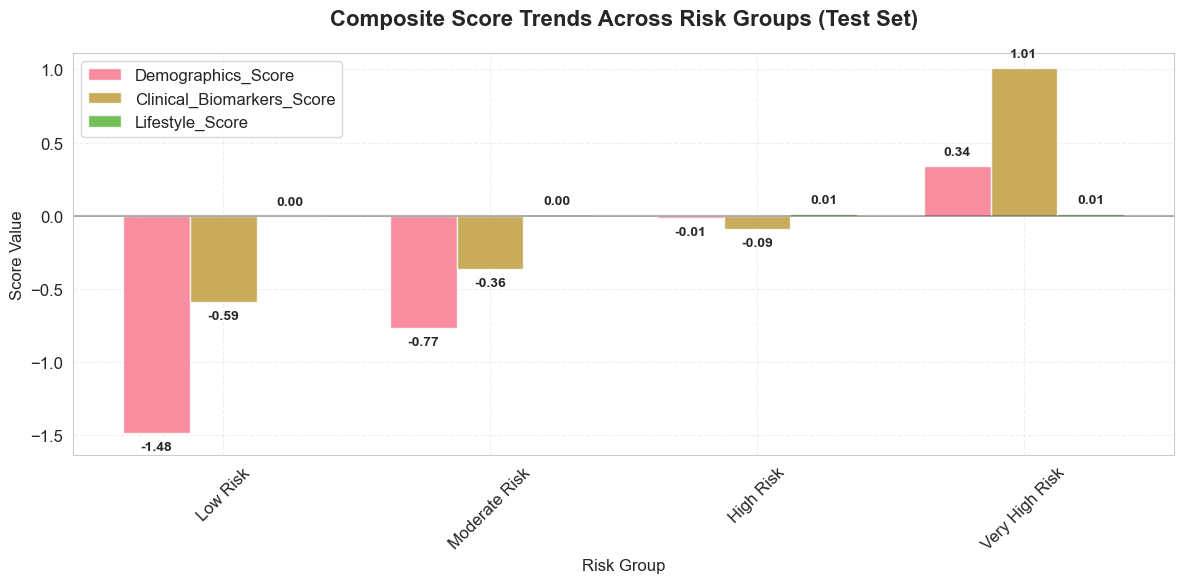

Plot saved to: P:\projects\heart_disease_prediction\reports\modeling\figures/3_composite_score_analysis.png


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==========================================================
# 1. SETUP: PATH LOGIC
# ==========================================================
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

FIGURES_DIR = project_root / 'reports' / 'modeling' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Creating composite score trend analysis...")

# ==========================================================
# 2. COMPOSITE SCORE TREND ANALYSIS - SINGLE PLOT
# ==========================================================
risk_order = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
composite_scores = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']

# Check which composite scores exist in test data
available_scores = [score for score in composite_scores if score in test_scores_df.columns]

if not available_scores:
    print("No composite scores found in test data. Using available numeric features.")
    # Use numeric features from the test data as composite scores
    numeric_features = test_scores_df.select_dtypes(include=[np.number]).columns.tolist()
    # Remove columns that are not features (like Risk_Score, Actual_Outcome)
    exclude_cols = ['Risk_Score', 'Actual_Outcome', 'Risk_Group']
    available_scores = [col for col in numeric_features if col not in exclude_cols]
    available_scores = available_scores[:3]  # Use first 3 numeric features

print(f"Using scores: {available_scores}")

# Create single plot
plt.figure(figsize=(12, 6))

# Get score means
score_means = test_scores_df.groupby('Risk_Group')[available_scores].mean().reindex(risk_order)

# Calculate y-axis limits to accommodate negative and positive values
all_values = score_means.values.flatten()
y_min = min(all_values) * 1.1  # 10% margin
y_max = max(all_values) * 1.1  # 10% margin

x_pos = np.arange(len(risk_order))
width = 0.25

# Plot each composite score
for i, score in enumerate(available_scores):
    offset = width * (i - (len(available_scores)-1)/2)
    bars = plt.bar(x_pos + offset, score_means[score], width, 
                   label=score, alpha=0.8)
    
    # Add value labels
    for bar, value in zip(bars, score_means[score]):
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        y_offset = 0.02 * (y_max - y_min) if height >= 0 else -0.02 * (y_max - y_min)
        plt.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                 f'{value:.2f}', ha='center', va=va, fontweight='bold', fontsize=10)

plt.xlabel('Risk Group')
plt.ylabel('Score Value')
plt.title('Composite Score Trends Across Risk Groups (Test Set)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x_pos, risk_order, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Zero line
plt.ylim(y_min, y_max)

plt.tight_layout()

# Save the plot
plt.savefig(FIGURES_DIR / '3_composite_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================
# 3. CLEAN UP UNNECESSARY VARIABLES
# ==========================================================
# Clean up temporary variables
del (score_means, all_values, y_min, y_max, x_pos, width, 
     bars, i, score, value, height, va, y_offset)
print(f"Plot saved to: {FIGURES_DIR}/3_composite_score_analysis.png")

### shap plot

Creating SHAP swarm plot...
Calculating SHAP values for 3 features using test data...
Using underlying model: XGBClassifier
SHAP values calculated successfully


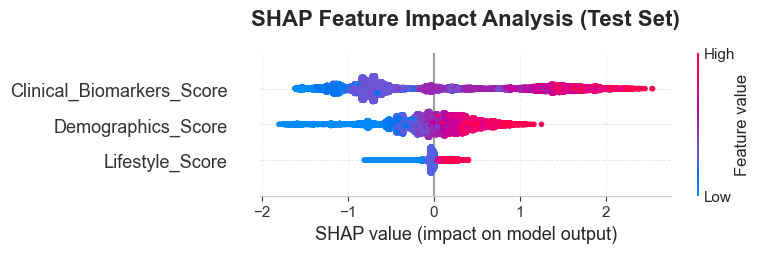


SHAP swarm plot completed!
Plot saved to: P:\projects\heart_disease_prediction\reports\modeling\figures/4_shap_swarm_plot.png


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from pathlib import Path

# ==========================================================
# 1. SETUP: PATH LOGIC
# ==========================================================
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

FIGURES_DIR = project_root / 'reports' / 'modeling' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Creating SHAP swarm plot...")

# ==========================================================
# 2. SHAP ANALYSIS SETUP
# ==========================================================
# Prepare test data for SHAP
if hasattr(X_test, 'columns'):
    feature_names = X_test.columns.tolist()
    X_test_shap = X_test
else:
    feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
    X_test_shap = pd.DataFrame(X_test, columns=feature_names)

print(f"Calculating SHAP values for {len(feature_names)} features using test data...")

# ==========================================================
# 3. CALCULATE SHAP VALUES
# ==========================================================
# Get the underlying model from CalibratedClassifierCV
# Access the estimator directly from the calibrated classifier
underlying_model = calibrated_model.calibrated_classifiers_[0].estimator

print(f"Using underlying model: {type(underlying_model).__name__}")

# Initialize SHAP explainer with the underlying model
if best_model_name == "xgboost":
    explainer = shap.TreeExplainer(underlying_model)
elif best_model_name == "lightgbm":
    explainer = shap.TreeExplainer(underlying_model)
else:
    explainer = shap.Explainer(underlying_model, X_test_shap)

# Calculate SHAP values for test set only
shap_values = explainer(X_test_shap)

print("SHAP values calculated successfully")

# ==========================================================
# 4. CREATE SHAP SWARM PLOT (DOT PLOT)
# ==========================================================
plt.figure(figsize=(12, 8))

# Create SHAP dot plot (swarm plot without bars)
shap.summary_plot(shap_values.values, X_test_shap, 
                  feature_names=feature_names,
                  plot_type="dot",
                  show=False,
                  max_display=15)

plt.title('SHAP Feature Impact Analysis (Test Set)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

# Save the SHAP plot
plt.savefig(FIGURES_DIR / '4_shap_swarm_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================
# 5. CLEAN UP AND SUMMARY
# ==========================================================
# Clean up temporary variables
del (explainer, shap_values, X_test_shap, underlying_model)

print(f"\nSHAP swarm plot completed!")
print(f"Plot saved to: {FIGURES_DIR}/4_shap_swarm_plot.png")

In [19]:
X_test_full.columns

Index(['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'BMI', 'BP_level', 'Pulse_Pressure',
       'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score'],
      dtype='object')

### Training a new model to improve the explainability of the scores

In [26]:
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import optuna
from sklearn.linear_model import LogisticRegression
import warnings
import joblib
import sys

warnings.filterwarnings('ignore')

# ==========================================================
# 1. CORRECT PATH CONFIGURATION
# ==========================================================

current_dir = Path().resolve()

# Correct path logic - if src exists in parents, go to project root
if "src" in [p.name for p in current_dir.parents]:
    # Find the src directory and go to its parent (project root)
    src_dir = [p for p in current_dir.parents if p.name == "src"][0]
    PROJECT_ROOT = src_dir.parent
else:
    PROJECT_ROOT = current_dir

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
REPORTS_DIR = PROJECT_ROOT / 'reports'
MODELS_DIR = REPORTS_DIR / 'modeling' / 'best model'

# Create directories only if they don't exist
if not ARTIFACTS_DIR.exists():
    ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
if not REPORTS_DIR.exists():
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
if not MODELS_DIR.exists():
    MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Artifacts directory: {ARTIFACTS_DIR}")
print(f"Models directory: {MODELS_DIR}")

# ==========================================================
# 2. DATA LOADING
# ==========================================================

def load_data_safely(file_path, description):
    try:
        if not file_path.exists():
            raise FileNotFoundError(f"File not found: {file_path}")
        
        data = pd.read_parquet(file_path)
        print(f"Loaded {description}: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading {description}: {e}")
        sys.exit(1)

# Load the actual data files
X_train_full = load_data_safely(ARTIFACTS_DIR / 'X_train.parquet', 'X_train')
X_test_full = load_data_safely(ARTIFACTS_DIR / 'X_test.parquet', 'X_test')
y_train = load_data_safely(ARTIFACTS_DIR / 'y_train.parquet', 'y_train').iloc[:, 0]
y_test = load_data_safely(ARTIFACTS_DIR / 'y_test.parquet', 'y_test').iloc[:, 0]

print(f"\nOriginal X_train shape: {X_train_full.shape}")
print(f"Original X_test shape: {X_test_full.shape}")

# ==========================================================
# 3. DATA PREPROCESSING
# ==========================================================

# Define the composite scores to exclude
composite_scores = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']

# Remove composite scores if they exist
X_train_full = X_train_full.drop(columns=composite_scores, errors='ignore')
X_test_full = X_test_full.drop(columns=composite_scores, errors='ignore')

print(f"After removing composite scores - X_train shape: {X_train_full.shape}")
print(f"After removing composite scores - X_test shape: {X_test_full.shape}")

# Define the specific columns to use
feature_cols = ['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
               'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
               'Physical_Activity', 'BMI', 'BP_level', 'Pulse_Pressure']

# Select only the required columns
X_train_full = X_train_full[feature_cols]
X_test_full = X_test_full[feature_cols]

print(f"After selecting feature columns - X_train shape: {X_train_full.shape}")
print(f"After selecting feature columns - X_test shape: {X_test_full.shape}")

# Check data types and unique values for cholesterol and glucose
print("\nCholesterol_Level unique values:", sorted(X_train_full['Cholesterol_Level'].unique()))
print("Glucose_Level unique values:", sorted(X_train_full['Glucose_Level'].unique()))

# Since Cholesterol_Level and Glucose_Level already have proper ordinal values [0, 1, 2],
# we don't need to apply additional ordinal encoding. They can be used as-is.
# Define preprocessor - no transformation needed for cholesterol and glucose
preprocessor = ColumnTransformer(
    transformers=[
        # No transformations needed since values are already properly encoded
    ],
    remainder='passthrough'  # All columns pass through unchanged
)

print(f"\nNo encoding applied - Cholesterol_Level and Glucose_Level already have ordinal values [0, 1, 2]")
print("All features used as-is")

# ==========================================================
# 4. BASELINE LOGISTIC REGRESSION
# ==========================================================

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced'))
])

print("\nTraining baseline Logistic Regression...")
lr_pipeline.fit(X_train_full, y_train)
lr_weights = np.abs(lr_pipeline.named_steps['classifier'].coef_[0])
lr_weights_normalized = lr_weights / np.sum(lr_weights)

print(f"LR feature weights calculated: {len(lr_weights_normalized)} features")

# ==========================================================
# 5. AUTO-STOPPING CALLBACK FOR OPTUNA
# ==========================================================

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    pass

class EarlyStoppingCallback:
    def __init__(self, early_stopping_rounds: int, direction: str = "maximize"):
        self.early_stopping_rounds = early_stopping_rounds
        self.direction = direction
        self._best_value = None
        self._no_improvement_count = 0

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        current_value = trial.value
        
        if current_value is None:
            return

        if self._best_value is None:
            self._best_value = current_value
            return

        if self.direction == "maximize":
            improved = current_value > self._best_value
        else:
            improved = current_value < self._best_value

        if improved:
            self._best_value = current_value
            self._no_improvement_count = 0
        else:
            self._no_improvement_count += 1

        if self._no_improvement_count >= self.early_stopping_rounds:
            raise EarlyStoppingExceeded()

# ==========================================================
# 6. HYPERPARAMETER OPTIMIZATION WITH AUTO-STOPPING
# ==========================================================

def calculate_fnr_fpr(y_true, y_pred):
    """Calculate False Negative Rate and False Positive Rate"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    return fnr, fpr

def objective(trial, model_name):
    penalty_strength = trial.suggest_float("penalty_strength", 0.0, 3.0)
    
    if model_name == 'xgb':
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
            "random_state": 42,
            "n_jobs": -1
        }
        model = xgb.XGBClassifier(**params)
    else:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "num_leaves": trial.suggest_int("num_leaves", 15, 100),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "random_state": 42,
            "n_jobs": -1,
            "verbose": -1
        }
        model = lgb.LGBMClassifier(**params)
    
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(pipe, X_train_full, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
    auc_score = np.mean(auc_scores)
    
    pipe.fit(X_train_full, y_train)
    model_importances = pipe.named_steps['model'].feature_importances_
    model_importances_normalized = model_importances / np.sum(model_importances)
    
    penalty = np.mean((model_importances_normalized - lr_weights_normalized) ** 2)
    final_score = auc_score - (penalty * penalty_strength)
    
    # Calculate FNR and FPR for the current model
    y_pred = pipe.predict(X_train_full)
    fnr, fpr = calculate_fnr_fpr(y_train, y_pred)
    
    # Store FNR and FPR as trial attributes
    trial.set_user_attr("auc", auc_score)
    trial.set_user_attr("penalty", penalty)
    trial.set_user_attr("fnr", fnr)
    trial.set_user_attr("fpr", fpr)
    trial.set_user_attr("fnr_fpr_gap", abs(fnr - fpr))
    
    return final_score

print("\nOptimizing XGBoost with auto-stopping...")
study_xgb = optuna.create_study(direction="maximize", study_name="xgb_optimization")
early_stopping_xgb = EarlyStoppingCallback(early_stopping_rounds=15, direction="maximize")

try:
    study_xgb.optimize(lambda trial: objective(trial, 'xgb'), n_trials=50, 
                      callbacks=[early_stopping_xgb], show_progress_bar=True)
    xgb_stopped_early = False
except EarlyStoppingExceeded:
    print("XGBoost optimization stopped early - no improvement for 15 trials")
    xgb_stopped_early = True

print("\nOptimizing LightGBM with auto-stopping...")
study_lgb = optuna.create_study(direction="maximize", study_name="lgb_optimization")
early_stopping_lgb = EarlyStoppingCallback(early_stopping_rounds=15, direction="maximize")

try:
    study_lgb.optimize(lambda trial: objective(trial, 'lgb'), n_trials=50, 
                      callbacks=[early_stopping_lgb], show_progress_bar=True)
    lgb_stopped_early = False
except EarlyStoppingExceeded:
    print("LightGBM optimization stopped early - no improvement for 15 trials")
    lgb_stopped_early = True

print(f"\nXGBoost trials completed: {len(study_xgb.trials)}, stopped early: {xgb_stopped_early}")
print(f"LightGBM trials completed: {len(study_lgb.trials)}, stopped early: {lgb_stopped_early}")

# ==========================================================
# 7. SELECT BEST MODEL WITH FNR < FPR CONDITION
# ==========================================================

def find_best_model_with_condition(study_xgb, study_lgb):
    """Find the best model that satisfies FNR < FPR with smallest gap"""
    
    # Collect all trials from both studies
    all_trials = []
    
    for trial in study_xgb.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            all_trials.append({
                'study': 'xgb',
                'trial': trial,
                'value': trial.value,
                'fnr': trial.user_attrs.get('fnr', 1.0),
                'fpr': trial.user_attrs.get('fpr', 1.0),
                'gap': trial.user_attrs.get('fnr_fpr_gap', 1.0)
            })
    
    for trial in study_lgb.trials:
        if trial.state == optuna.trial.TrialState.COMPLETE:
            all_trials.append({
                'study': 'lgb',
                'trial': trial,
                'value': trial.value,
                'fnr': trial.user_attrs.get('fnr', 1.0),
                'fpr': trial.user_attrs.get('fpr', 1.0),
                'gap': trial.user_attrs.get('fnr_fpr_gap', 1.0)
            })
    
    # Filter trials that satisfy FNR < FPR
    valid_trials = [t for t in all_trials if t['fnr'] < t['fpr']]
    
    if valid_trials:
        # Find the trial with the smallest gap between FNR and FPR
        best_trial = min(valid_trials, key=lambda x: x['gap'])
        print(f"\nFound {len(valid_trials)} trials satisfying FNR < FPR")
        print(f"Best trial: {best_trial['study'].upper()} with gap {best_trial['gap']:.4f}")
        print(f"FNR: {best_trial['fnr']:.4f}, FPR: {best_trial['fpr']:.4f}")
        return best_trial
    else:
        # If no trials satisfy FNR < FPR, use the original best model
        print("\nNo trials satisfy FNR < FPR condition, using best overall model")
        if study_xgb.best_value >= study_lgb.best_value:
            best_trial = {
                'study': 'xgb',
                'trial': study_xgb.best_trial,
                'value': study_xgb.best_value,
                'fnr': study_xgb.best_trial.user_attrs.get('fnr', 1.0),
                'fpr': study_xgb.best_trial.user_attrs.get('fpr', 1.0),
                'gap': study_xgb.best_trial.user_attrs.get('fnr_fpr_gap', 1.0)
            }
        else:
            best_trial = {
                'study': 'lgb',
                'trial': study_lgb.best_trial,
                'value': study_lgb.best_value,
                'fnr': study_lgb.best_trial.user_attrs.get('fnr', 1.0),
                'fpr': study_lgb.best_trial.user_attrs.get('fpr', 1.0),
                'gap': study_lgb.best_trial.user_attrs.get('fnr_fpr_gap', 1.0)
            }
        print(f"Best overall: {best_trial['study'].upper()} with gap {best_trial['gap']:.4f}")
        print(f"FNR: {best_trial['fnr']:.4f}, FPR: {best_trial['fpr']:.4f}")
        return best_trial

# Find the best model with FNR < FPR condition
best_trial_info = find_best_model_with_condition(study_xgb, study_lgb)

if best_trial_info['study'] == 'xgb':
    best_params = best_trial_info['trial'].params.copy()
    model_builder = xgb.XGBClassifier
    model_name = "XGBoost"
else:
    best_params = best_trial_info['trial'].params.copy()
    model_builder = lgb.LGBMClassifier
    model_name = "LightGBM"

best_params.pop("penalty_strength", None)
best_params['random_state'] = 42
best_params['n_jobs'] = -1

print(f"\nSelected model: {model_name}")
print(f"Selection criteria: FNR < FPR with smallest gap ({best_trial_info['gap']:.4f})")

final_model = model_builder(**best_params)
final_pipe = Pipeline([("preprocessor", preprocessor), ("model", final_model)])

# ==========================================================
# 8. CALIBRATE AND SAVE MODEL
# ==========================================================

print("Calibrating model...")
calibrated_model = CalibratedClassifierCV(estimator=final_pipe, method="isotonic", cv=5, n_jobs=-1)
calibrated_model.fit(X_train_full, y_train)

model_path = MODELS_DIR / 'calibrated_raw_feature_model.pkl'
# This will overwrite if file exists
joblib.dump(calibrated_model, model_path)
print(f"Model saved: {model_path}")

# ==========================================================
# 9. MODEL EVALUATION
# ==========================================================

y_test_proba = calibrated_model.predict_proba(X_test_full)[:, 1]
y_test_pred = calibrated_model.predict(X_test_full)
test_auc = roc_auc_score(y_test, y_test_proba)

# Calculate final FNR and FPR on test set
test_fnr, test_fpr = calculate_fnr_fpr(y_test, y_test_pred)

print(f"\nTest AUC: {test_auc:.4f}")
print(f"Test FNR: {test_fnr:.4f}")
print(f"Test FPR: {test_fpr:.4f}")
print(f"Test FNR-FPR gap: {abs(test_fnr - test_fpr):.4f}")
print(f"FNR < FPR condition satisfied: {test_fnr < test_fpr}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['No CVD', 'CVD']))

# ==========================================================
# 10. GENERATE RISK SCORES
# ==========================================================

def create_risk_groups(risk_scores):
    conditions = [
        risk_scores < 0.1,
        risk_scores < 0.25,
        risk_scores < 0.5,
        risk_scores >= 0.5
    ]
    choices = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
    return np.select(conditions, choices, default='Unknown')

# Generate predictions for both train and test sets
test_risk_scores_raw = calibrated_model.predict_proba(X_test_full)[:, 1]
test_risk_groups_raw = create_risk_groups(test_risk_scores_raw)

train_risk_scores_raw = calibrated_model.predict_proba(X_train_full)[:, 1]
train_risk_groups_raw = create_risk_groups(train_risk_scores_raw)

# Add raw feature model predictions to existing dataframes (already in memory)
test_scores_df['Raw_Risk_Score'] = test_risk_scores_raw
test_scores_df['Raw_Risk_Group'] = test_risk_groups_raw

train_scores_df['Raw_Risk_Score'] = train_risk_scores_raw
train_scores_df['Raw_Risk_Group'] = train_risk_groups_raw

print("\nRisk Distribution (Test Set):")
unique, counts = np.unique(test_risk_groups_raw, return_counts=True)
for group, count in zip(unique, counts):
    print(f"{group}: {count} ({count/len(test_risk_scores_raw)*100:.1f}%)")

print(f"\nUpdated test_scores_df columns: {test_scores_df.columns.tolist()}")
print(f"Updated train_scores_df columns: {train_scores_df.columns.tolist()}")

Project root: P:\projects\heart_disease_prediction
Artifacts directory: P:\projects\heart_disease_prediction\artifacts
Models directory: P:\projects\heart_disease_prediction\reports\modeling\best model
Loaded X_train: (48983, 15)
Loaded X_test: (20993, 15)
Loaded y_train: (48983, 1)
Loaded y_test: (20993, 1)

Original X_train shape: (48983, 15)
Original X_test shape: (20993, 15)
After removing composite scores - X_train shape: (48983, 12)
After removing composite scores - X_test shape: (20993, 12)
After selecting feature columns - X_train shape: (48983, 12)
After selecting feature columns - X_test shape: (20993, 12)

Cholesterol_Level unique values: [0.0, 1.0, 2.0]
Glucose_Level unique values: [0.0, 1.0, 2.0]

No encoding applied - Cholesterol_Level and Glucose_Level already have ordinal values [0, 1, 2]
All features used as-is

Training baseline Logistic Regression...
LR feature weights calculated: 12 features

Optimizing XGBoost with auto-stopping...


Best trial: 42. Best value: 0.80274: 100%|██████████| 50/50 [03:14<00:00,  3.89s/it] 



Optimizing LightGBM with auto-stopping...


Best trial: 33. Best value: 0.802271:  96%|█████████▌| 48/50 [04:12<00:10,  5.26s/it]


LightGBM optimization stopped early - no improvement for 15 trials

XGBoost trials completed: 50, stopped early: False
LightGBM trials completed: 49, stopped early: True

Found 45 trials satisfying FNR < FPR
Best trial: XGB with gap 0.0581
FNR: 0.2358, FPR: 0.2939

Selected model: XGBoost
Selection criteria: FNR < FPR with smallest gap (0.0581)
Calibrating model...
Model saved: P:\projects\heart_disease_prediction\reports\modeling\best model\calibrated_raw_feature_model.pkl

Test AUC: 0.8016
Test FNR: 0.3063
Test FPR: 0.2225
Test FNR-FPR gap: 0.0839
FNR < FPR condition satisfied: False

Classification Report:
              precision    recall  f1-score   support

      No CVD       0.72      0.78      0.75     10501
         CVD       0.76      0.69      0.72     10492

    accuracy                           0.74     20993
   macro avg       0.74      0.74      0.74     20993
weighted avg       0.74      0.74      0.74     20993


Risk Distribution (Test Set):
High Risk: 6573 (31.3%)
L

### comparing both scores

COMPARING TWO RISK SCORING METHODS
✅ Comparing: 'CHDRI_Score' vs 'Raw_Risk_Score'
   Test Set Size: 20993

SCORE DISTRIBUTION COMPARISON


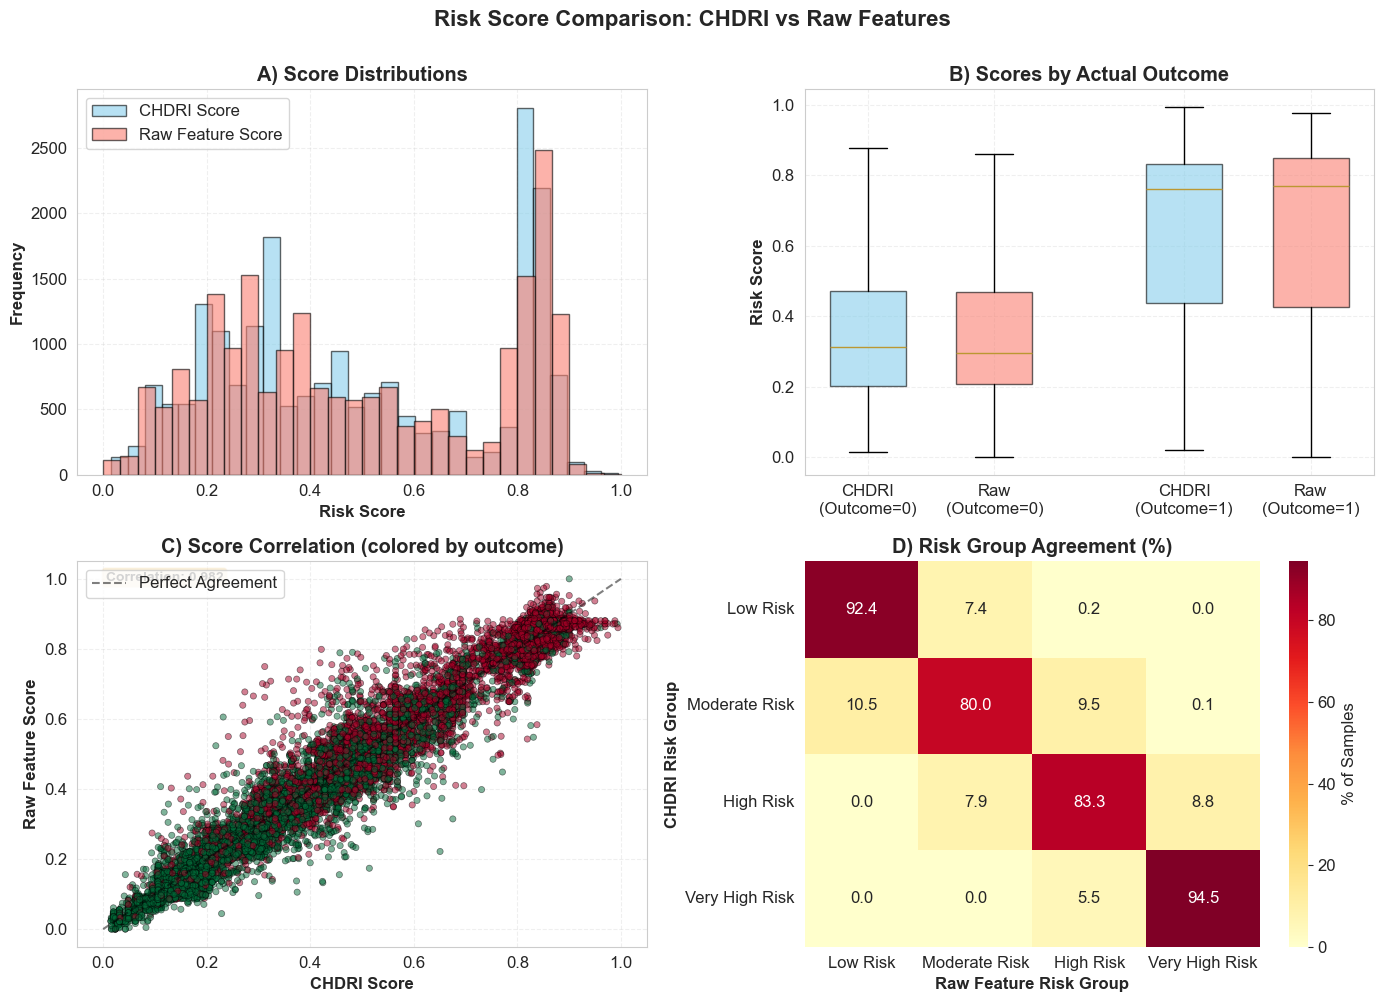


RISK GROUP DISTRIBUTION & CVD RATES


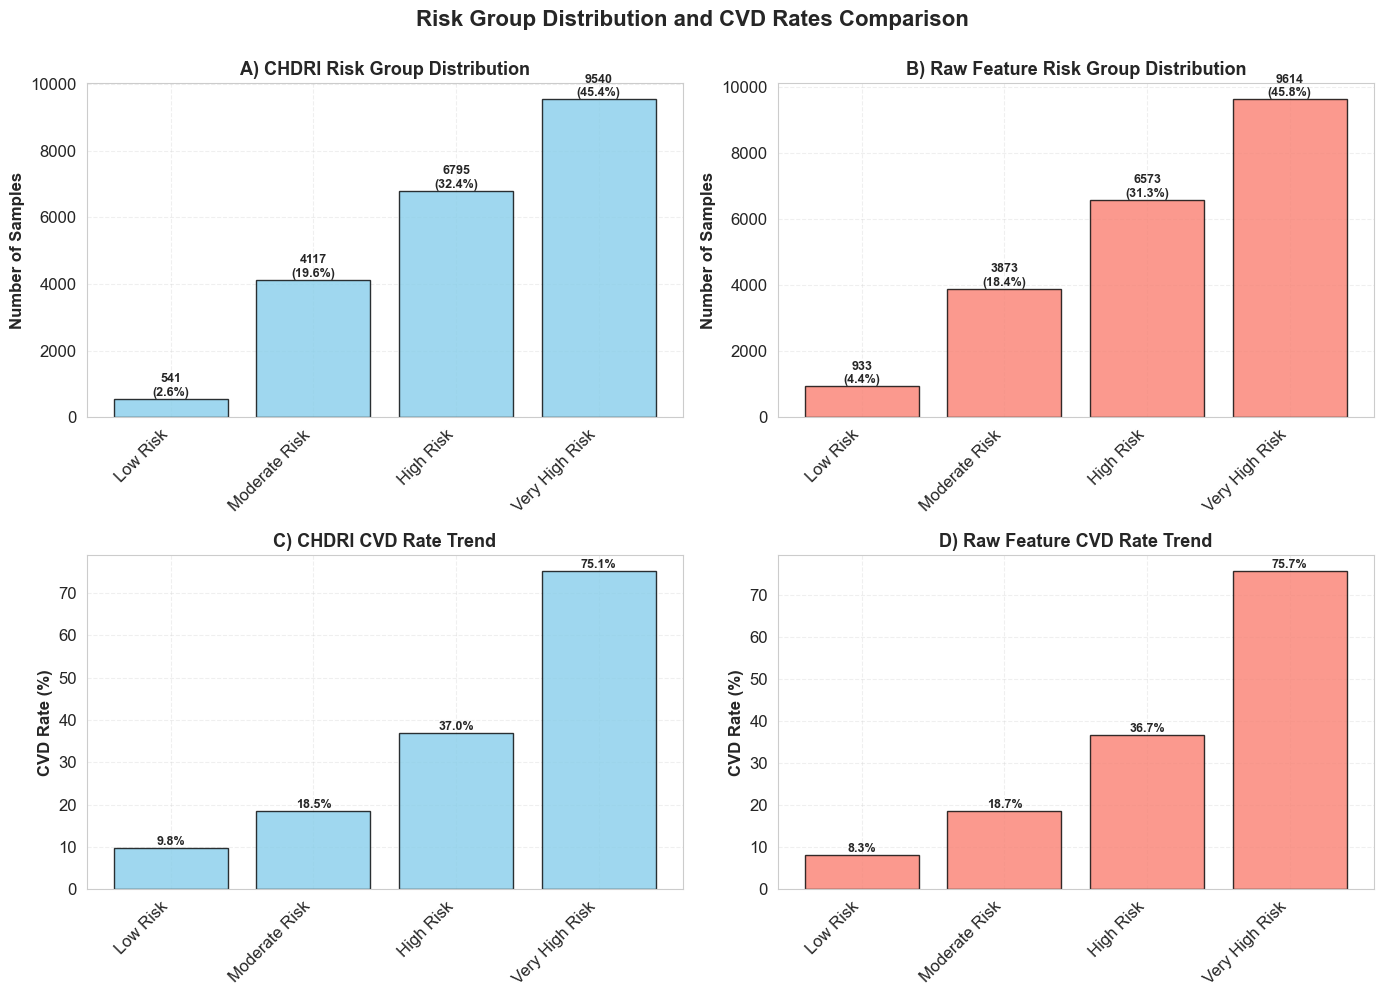


RISK GROUP AGREEMENT HEATMAP


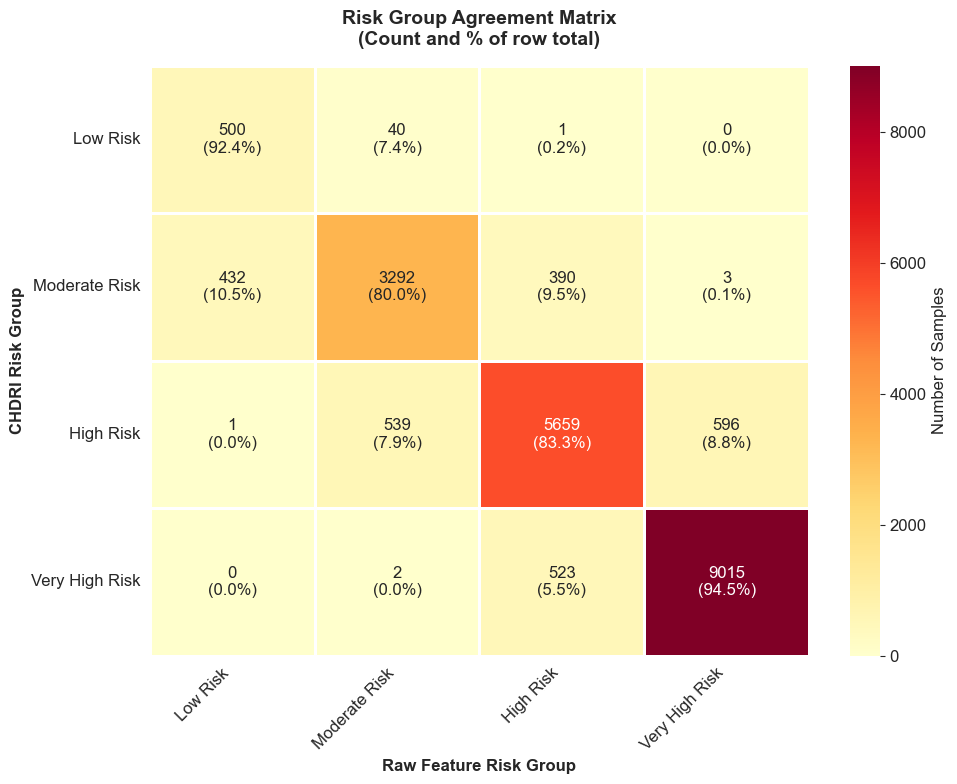


SUMMARY STATISTICS

📊 Score Statistics:
   CHDRI Score:
      Mean: 0.4987
      Std:  0.2632
      Min:  0.0148
      Max:  0.9944

   Raw Feature Score:
      Mean: 0.4988
      Std:  0.2672
      Min:  0.0000
      Max:  1.0000

   Correlation: 0.9816

📊 Risk Group Agreement:
   Exact Agreement: 87.96%
   Within 1 Category: 99.97%

📊 Risk Group Distribution Comparison:

   CHDRI:
      Low Risk            :  541 (  2.6%)
      Moderate Risk       : 4117 ( 19.6%)
      High Risk           : 6795 ( 32.4%)
      Very High Risk      : 9540 ( 45.4%)

   Raw Features:
      Low Risk            :  933 (  4.4%)
      Moderate Risk       : 3873 ( 18.4%)
      High Risk           : 6573 ( 31.3%)
      Very High Risk      : 9614 ( 45.8%)

📊 CVD Rate Comparison by Risk Group:
   Risk Group                CHDRI    Raw Features   Difference
   ------------------------------------------------------------
   Low Risk                   9.8%            8.3%       -1.5%
   Moderate Risk             1

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ==========================================================
# 1. SETUP: PATH LOGIC
# ==========================================================
current_dir = Path().resolve()
if "src" in [p.name.lower() for p in current_dir.parents]:
    project_root = [p for p in current_dir.parents if p.name.lower() == "src"][0].parent
else:
    project_root = current_dir

FIGURES_DIR = project_root / 'reports' / 'modeling' / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("COMPARING TWO RISK SCORING METHODS")
print("=" * 70)

# ==========================================================
# 2. SCORE COMPARISON SETUP
# ==========================================================
# Define the two scoring methods to compare
score_1_name = 'CHDRI_Score'  # Composite-based score
score_2_name = 'Raw_Risk_Score'  # Raw feature-based score
group_1_name = 'Risk_Group'  # Composite-based risk groups
group_2_name = 'Raw_Risk_Group'  # Raw feature-based risk groups

# Verify columns exist
required_cols = [score_1_name, score_2_name, group_1_name, group_2_name, 'Actual_Outcome']
missing_cols = [col for col in required_cols if col not in test_scores_df.columns]

if missing_cols:
    print(f"❌ Missing columns: {missing_cols}")
    print(f"Available columns: {test_scores_df.columns.tolist()}")
    raise ValueError(f"Required columns not found in test_scores_df")

print(f"✅ Comparing: '{score_1_name}' vs '{score_2_name}'")
print(f"   Test Set Size: {len(test_scores_df)}")

# ==========================================================
# 3. SCORE DISTRIBUTION COMPARISON
# ==========================================================
print("\n" + "=" * 70)
print("SCORE DISTRIBUTION COMPARISON")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Risk Score Comparison: CHDRI vs Raw Features', 
             fontsize=16, fontweight='bold', y=1.00)

# Plot 1: Score Distributions
axes[0, 0].hist(test_scores_df[score_1_name], bins=30, alpha=0.6, 
                label='CHDRI Score', color='skyblue', edgecolor='black')
axes[0, 0].hist(test_scores_df[score_2_name], bins=30, alpha=0.6, 
                label='Raw Feature Score', color='salmon', edgecolor='black')
axes[0, 0].set_xlabel('Risk Score', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title('A) Score Distributions', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Box Plots by Actual Outcome
data_for_box = pd.DataFrame({
    'CHDRI Score': test_scores_df[score_1_name],
    'Raw Feature Score': test_scores_df[score_2_name],
    'Outcome': test_scores_df['Actual_Outcome']
})

box_data = []
labels = []
positions = []
pos = 1

for outcome in [0, 1]:
    box_data.append(data_for_box[data_for_box['Outcome'] == outcome]['CHDRI Score'])
    labels.append(f'CHDRI\n(Outcome={outcome})')
    positions.append(pos)
    pos += 1
    
    box_data.append(data_for_box[data_for_box['Outcome'] == outcome]['Raw Feature Score'])
    labels.append(f'Raw\n(Outcome={outcome})')
    positions.append(pos)
    pos += 1.5

bp = axes[0, 1].boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                         labels=labels, showfliers=False)

# Color the boxes
colors = ['skyblue', 'salmon'] * 2
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0, 1].set_ylabel('Risk Score', fontweight='bold')
axes[0, 1].set_title('B) Scores by Actual Outcome', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Scatter Plot - Direct Comparison
axes[1, 0].scatter(test_scores_df[score_1_name], test_scores_df[score_2_name], 
                   alpha=0.5, s=20, c=test_scores_df['Actual_Outcome'], 
                   cmap='RdYlGn_r', edgecolors='black', linewidth=0.5)
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Agreement')
axes[1, 0].set_xlabel('CHDRI Score', fontweight='bold')
axes[1, 0].set_ylabel('Raw Feature Score', fontweight='bold')
axes[1, 0].set_title('C) Score Correlation (colored by outcome)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Calculate correlation
correlation = test_scores_df[score_1_name].corr(test_scores_df[score_2_name])
axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=axes[1, 0].transAxes, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontsize=10, fontweight='bold')

# Plot 4: Risk Group Agreement Matrix
risk_order_chdri = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
risk_order_raw = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']

# Create confusion-like matrix
agreement_matrix = pd.crosstab(
    test_scores_df[group_1_name], 
    test_scores_df[group_2_name],
    normalize='index'
) * 100  # Convert to percentages

# Reindex to ensure proper order
agreement_matrix = agreement_matrix.reindex(
    index=risk_order_chdri, 
    columns=risk_order_raw, 
    fill_value=0
)

sns.heatmap(agreement_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            ax=axes[1, 1], cbar_kws={'label': '% of Samples'})
axes[1, 1].set_xlabel('Raw Feature Risk Group', fontweight='bold')
axes[1, 1].set_ylabel('CHDRI Risk Group', fontweight='bold')
axes[1, 1].set_title('D) Risk Group Agreement (%)', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / '4_score_comparison_overview.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================
# 4. RISK GROUP ANALYSIS - DISTRIBUTION & CVD RATES
# ==========================================================
print("\n" + "=" * 70)
print("RISK GROUP DISTRIBUTION & CVD RATES")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Risk Group Distribution and CVD Rates Comparison', 
             fontsize=16, fontweight='bold', y=0.995)

# Calculate distributions
group_1_dist = test_scores_df[group_1_name].value_counts().reindex(risk_order_chdri, fill_value=0)
group_1_pct = (group_1_dist / len(test_scores_df) * 100)
group_2_dist = test_scores_df[group_2_name].value_counts().reindex(risk_order_raw, fill_value=0)
group_2_pct = (group_2_dist / len(test_scores_df) * 100)

# Calculate CVD rates
def calc_positive_rate(df, group_col, risk_order):
    rates = []
    for risk_group in risk_order:
        mask = df[group_col] == risk_group
        if mask.sum() > 0:
            rate = df[mask]['Actual_Outcome'].mean() * 100
        else:
            rate = 0
        rates.append(rate)
    return rates

chdri_rates = calc_positive_rate(test_scores_df, group_1_name, risk_order_chdri)
raw_rates = calc_positive_rate(test_scores_df, group_2_name, risk_order_raw)

# TOP LEFT: CHDRI Risk Group Distribution
bars1 = axes[0, 0].bar(range(len(group_1_dist)), group_1_dist.values, 
                       color='skyblue', alpha=0.8, edgecolor='black')
axes[0, 0].set_xticks(range(len(risk_order_chdri)))
axes[0, 0].set_xticklabels(risk_order_chdri, rotation=45, ha='right')
axes[0, 0].set_ylabel('Number of Samples', fontweight='bold')
axes[0, 0].set_title('A) CHDRI Risk Group Distribution', fontweight='bold', fontsize=13)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for bar, count, pct in zip(bars1, group_1_dist.values, group_1_pct.values):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)

# TOP RIGHT: Raw Features Risk Group Distribution
bars2 = axes[0, 1].bar(range(len(group_2_dist)), group_2_dist.values, 
                       color='salmon', alpha=0.8, edgecolor='black')
axes[0, 1].set_xticks(range(len(risk_order_raw)))
axes[0, 1].set_xticklabels(risk_order_raw, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Samples', fontweight='bold')
axes[0, 1].set_title('B) Raw Feature Risk Group Distribution', fontweight='bold', fontsize=13)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add percentage labels
for bar, count, pct in zip(bars2, group_2_dist.values, group_2_pct.values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)

# BOTTOM LEFT: CHDRI CVD Rate Trend
bars3 = axes[1, 0].bar(range(len(chdri_rates)), chdri_rates, 
                       color='skyblue', alpha=0.8, edgecolor='black')
axes[1, 0].set_xticks(range(len(risk_order_chdri)))
axes[1, 0].set_xticklabels(risk_order_chdri, rotation=45, ha='right')
axes[1, 0].set_ylabel('CVD Rate (%)', fontweight='bold')
axes[1, 0].set_title('C) CHDRI CVD Rate Trend', fontweight='bold', fontsize=13)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, rate in zip(bars3, chdri_rates):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{rate:.1f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)

# BOTTOM RIGHT: Raw Features CVD Rate Trend
bars4 = axes[1, 1].bar(range(len(raw_rates)), raw_rates, 
                       color='salmon', alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(range(len(risk_order_raw)))
axes[1, 1].set_xticklabels(risk_order_raw, rotation=45, ha='right')
axes[1, 1].set_ylabel('CVD Rate (%)', fontweight='bold')
axes[1, 1].set_title('D) Raw Feature CVD Rate Trend', fontweight='bold', fontsize=13)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, rate in zip(bars4, raw_rates):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{rate:.1f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '5_risk_group_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================
# 5. RISK GROUP AGREEMENT HEATMAP
# ==========================================================
print("\n" + "=" * 70)
print("RISK GROUP AGREEMENT HEATMAP")
print("=" * 70)

fig, ax = plt.subplots(figsize=(10, 8))

# Create confusion-like matrix (showing counts)
agreement_matrix_counts = pd.crosstab(
    test_scores_df[group_1_name], 
    test_scores_df[group_2_name]
)

# Reindex to ensure proper order
agreement_matrix_counts = agreement_matrix_counts.reindex(
    index=risk_order_chdri, 
    columns=risk_order_raw, 
    fill_value=0
)

# Calculate percentages for annotations
agreement_matrix_pct = pd.crosstab(
    test_scores_df[group_1_name], 
    test_scores_df[group_2_name],
    normalize='index'
) * 100

agreement_matrix_pct = agreement_matrix_pct.reindex(
    index=risk_order_chdri, 
    columns=risk_order_raw, 
    fill_value=0
)

# Create custom annotations (count + percentage)
annot = np.empty_like(agreement_matrix_counts.values, dtype=object)
for i in range(agreement_matrix_counts.shape[0]):
    for j in range(agreement_matrix_counts.shape[1]):
        count = agreement_matrix_counts.iloc[i, j]
        pct = agreement_matrix_pct.iloc[i, j]
        annot[i, j] = f'{count}\n({pct:.1f}%)'

# Plot heatmap
sns.heatmap(agreement_matrix_counts, annot=annot, fmt='', cmap='YlOrRd', 
            ax=ax, cbar_kws={'label': 'Number of Samples'},
            linewidths=1, linecolor='white')

ax.set_xlabel('Raw Feature Risk Group', fontweight='bold', fontsize=12)
ax.set_ylabel('CHDRI Risk Group', fontweight='bold', fontsize=12)
ax.set_title('Risk Group Agreement Matrix\n(Count and % of row total)', 
             fontweight='bold', fontsize=14, pad=15)

# Rotate labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / '6_risk_group_agreement_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================================
# 6. SUMMARY STATISTICS
# ==========================================================
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

print(f"\n📊 Score Statistics:")
print(f"   CHDRI Score:")
print(f"      Mean: {test_scores_df[score_1_name].mean():.4f}")
print(f"      Std:  {test_scores_df[score_1_name].std():.4f}")
print(f"      Min:  {test_scores_df[score_1_name].min():.4f}")
print(f"      Max:  {test_scores_df[score_1_name].max():.4f}")

print(f"\n   Raw Feature Score:")
print(f"      Mean: {test_scores_df[score_2_name].mean():.4f}")
print(f"      Std:  {test_scores_df[score_2_name].std():.4f}")
print(f"      Min:  {test_scores_df[score_2_name].min():.4f}")
print(f"      Max:  {test_scores_df[score_2_name].max():.4f}")

print(f"\n   Correlation: {correlation:.4f}")

# Calculate exact agreement
exact_agreement = (test_scores_df[group_1_name] == test_scores_df[group_2_name]).mean() * 100
print(f"\n📊 Risk Group Agreement:")
print(f"   Exact Agreement: {exact_agreement:.2f}%")

# Calculate within-one-category agreement
risk_map = {risk: i for i, risk in enumerate(risk_order_chdri)}
diff = abs(test_scores_df[group_1_name].map(risk_map) - test_scores_df[group_2_name].map(risk_map))
within_one = (diff <= 1).mean() * 100
print(f"   Within 1 Category: {within_one:.2f}%")

# Print distribution comparison
print(f"\n📊 Risk Group Distribution Comparison:")
print(f"\n   CHDRI:")
for risk, count, pct in zip(risk_order_chdri, group_1_dist.values, group_1_pct.values):
    print(f"      {risk:20s}: {count:4d} ({pct:5.1f}%)")

print(f"\n   Raw Features:")
for risk, count, pct in zip(risk_order_raw, group_2_dist.values, group_2_pct.values):
    print(f"      {risk:20s}: {count:4d} ({pct:5.1f}%)")

# Print CVD rate comparison
print(f"\n📊 CVD Rate Comparison by Risk Group:")
print(f"   {'Risk Group':<20s} {'CHDRI':>10s} {'Raw Features':>15s} {'Difference':>12s}")
print(f"   {'-'*60}")
for risk, chdri_rate, raw_rate in zip(risk_order_chdri, chdri_rates, raw_rates):
    diff = raw_rate - chdri_rate
    sign = '+' if diff > 0 else ''
    print(f"   {risk:<20s} {chdri_rate:>9.1f}% {raw_rate:>14.1f}% {sign}{diff:>10.1f}%")

print(f"\n✅ All plots saved to: {FIGURES_DIR}")
print("=" * 70)

### **Observation**

* **High Correlation:** The risk scores from the primary Composite (CHDRI) model and the secondary Raw Feature model show excellent statistical agreement and mimic each other's behavior very closely.

* **Superior Classification of the CHDRI Score:** Despite the strong correlation, the CHDRI model is more effective at capturing certain at-risk patients who are occasionally misclassified when using the Raw Feature model's risk group assignments.

* **Definitive Score for Performance:** Based on its superior classification accuracy, the **CHDRI score is considered the final and official measure** of patient risk for all performance reporting.

* **Role of the Raw Feature Model:** The Raw Feature model functions as a **surrogate or explanatory tool**. Its sole purpose is to provide insights into individual feature effects (via SHAP waterfall plots) that approximate the official CHDRI score.

* **Acknowledged Limitation:** We acknowledge that this two-model approach carries a minor, but acceptable, risk that the explanatory model will slightly misclassify a small portion of the population at the risk group thresholds.

In [ ]:
X_test_full.columns

Index(['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'BMI', 'BP_level', 'Pulse_Pressure'],
      dtype='object')

SHAP WATERFALL PLOT - RAW FEATURE MODEL
Loading RobustScaler from: P:\projects\heart_disease_prediction\artifacts\robust_scaler_numeric.pkl
✅ RobustScaler loaded successfully
Sample Index: 16535
True Label: 1 (Heart Disease)
Prediction Score: 0.2802
Risk Group: High Risk

Applying inverse transformation using saved RobustScaler...
✅ Inverse transformation completed

Creating SHAP explainer...
Calculating SHAP values...
Base value: 0.8485

Creating waterfall plot...


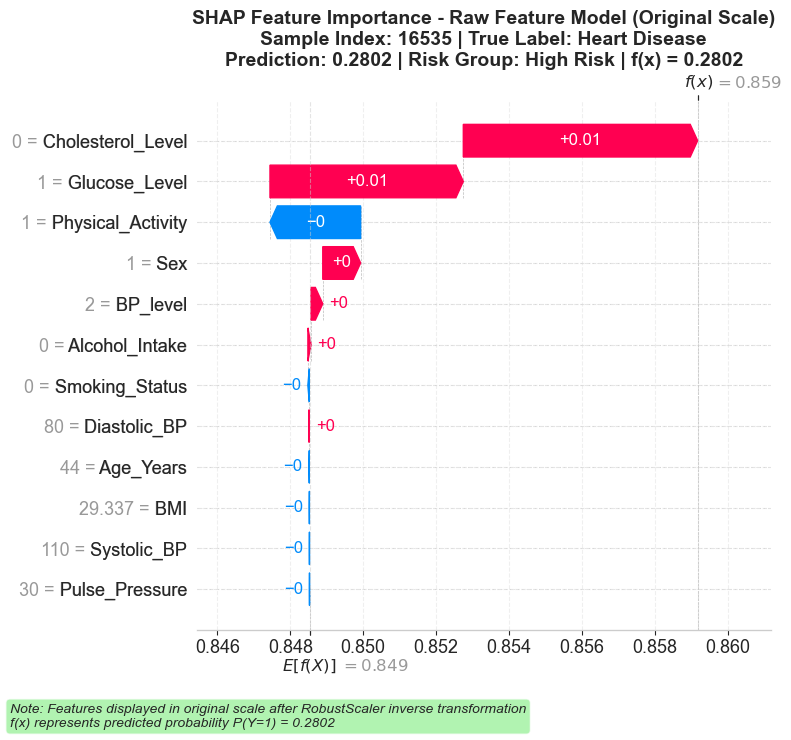

✅ SHAP waterfall plot completed successfully!


In [29]:
# ==========================================================
# SHAP WATERFALL PLOT FOR RAW FEATURE MODEL
# ==========================================================
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

# Set up SHAP
shap.initjs()

# -----------------------------
# Configuration
# -----------------------------
print("=" * 70)
print("SHAP WATERFALL PLOT - RAW FEATURE MODEL")
print("=" * 70)

# Define columns
feature_cols = ['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level', 
                'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity', 
                'BMI', 'BP_level', 'Pulse_Pressure']

# Define numerical columns that were scaled
numerical_cols = ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI', 'Pulse_Pressure']

# Load the saved RobustScaler
scaler_path = ARTIFACTS_DIR / 'robust_scaler_numeric.pkl'
print(f"Loading RobustScaler from: {scaler_path}")

try:
    robust_scaler = joblib.load(scaler_path)
    print("✅ RobustScaler loaded successfully")
except Exception as e:
    print(f"❌ Error loading RobustScaler: {e}")
    raise

# Create copies with only required columns
X_test_copy = X_test_full[feature_cols].copy(deep=True)

# Randomly sample from test data
np.random.seed(42)
available_indices = X_test_copy.index
sample_idx = np.random.choice(available_indices, size=1, replace=False)[0]
sample_instance = X_test_copy.loc[sample_idx:sample_idx+1]

print(f"Sample Index: {sample_idx}")
print(f"True Label: {y_test.loc[sample_idx]} ({'Heart Disease' if y_test.loc[sample_idx] == 1 else 'Healthy'})")

# -----------------------------
# Fetch risk data from scores_df
# -----------------------------
raw_score = test_scores_df.loc[sample_idx, 'Raw_Risk_Score']
raw_risk_group = test_scores_df.loc[sample_idx, 'Raw_Risk_Group']

print(f"Prediction Score: {raw_score:.4f}")
print(f"Risk Group: {raw_risk_group}")

# -----------------------------
# INVERSE TRANSFORMATION USING SAVED ROBUSTSCALER
# -----------------------------

def inverse_transform_with_saved_scaler(scaled_df, numerical_cols, scaler):
    """Apply inverse transformation using the saved RobustScaler"""
    original_df = scaled_df.copy()
    scaled_numerical_data = scaled_df[numerical_cols].values
    original_numerical_data = scaler.inverse_transform(scaled_numerical_data)
    
    for i, col in enumerate(numerical_cols):
        original_df[col] = original_numerical_data[:, i]
    
    return original_df

print("\nApplying inverse transformation using saved RobustScaler...")
sample_original = inverse_transform_with_saved_scaler(sample_instance, numerical_cols, robust_scaler)
background_original = inverse_transform_with_saved_scaler(X_test_copy.iloc[:50], numerical_cols, robust_scaler)
print("✅ Inverse transformation completed")

# Use original features for SHAP explanation
sample_for_shap = sample_original
background_data = background_original

# -----------------------------
# SHAP Explanation
# -----------------------------

def calibrated_predict_proba(X):
    """Wrapper function for SHAP"""
    if isinstance(X, pd.DataFrame):
        return calibrated_model.predict_proba(X)[:, 1]
    else:
        X_df = pd.DataFrame(X, columns=feature_cols)
        return calibrated_model.predict_proba(X_df)[:, 1]

print("\nCreating SHAP explainer...")

try:
    background_array = background_data.values
    feature_names = background_data.columns.tolist()
    
    explainer = shap.KernelExplainer(calibrated_predict_proba, background_array)
    sample_array = sample_for_shap.values[0]

    # Get SHAP values
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(sample_array)

    # Handle SHAP output formats
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]
    elif hasattr(shap_values, 'shape') and len(shap_values.shape) == 2:
        shap_values = shap_values[0]

    if len(shap_values) > len(feature_names):
        shap_values = shap_values[:len(feature_names)]

    # Get base value
    base_value = explainer.expected_value
    if isinstance(base_value, np.ndarray) and len(base_value) > 1:
        base_value = base_value[1]

    print(f"Base value: {base_value:.4f}")

except Exception as e:
    print(f"SHAP explanation failed: {e}")
    try:
        print("Trying TreeExplainer as alternative...")
        explainer = shap.TreeExplainer(calibrated_model.named_steps['model'])
        shap_values = explainer.shap_values(sample_for_shap)
        base_value = explainer.expected_value
        
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
            
        print(f"TreeExplainer successful! Base value: {base_value:.4f}")
        
    except Exception as e2:
        print(f"Alternative approach also failed: {e2}")
        raise

# -----------------------------
# Create Waterfall Plot Only
# -----------------------------
print("\nCreating waterfall plot...")

plt.figure(figsize=(16, 10))

# Create explanation with original feature values
explanation = shap.Explanation(
    values=shap_values,
    base_values=base_value,
    data=sample_array,
    feature_names=feature_names
)

# Create waterfall plot
shap.waterfall_plot(explanation, max_display=15, show=False)

# Customize the plot
plt.title(f'SHAP Feature Importance - Raw Feature Model (Original Scale)\n'
          f'Sample Index: {sample_idx} | True Label: {"Heart Disease" if y_test.loc[sample_idx] == 1 else "Healthy"}\n'
          f'Prediction: {raw_score:.4f} | Risk Group: {raw_risk_group} | f(x) = {raw_score:.4f}',
          fontsize=14, fontweight='bold', pad=25)

# Add annotation
annotation_text = (
    f'Note: Features displayed in original scale after RobustScaler inverse transformation\n'
    f'f(x) represents predicted probability P(Y=1) = {raw_score:.4f}'
)

plt.figtext(0.02, 0.02, annotation_text, 
            fontsize=10, style='italic', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print("✅ SHAP waterfall plot completed successfully!")